# Analyze MCE data taken on TmVO4 samples
either in DR (plate-like sample) or in He3 (needles)

In [1]:
# Standard Python libraries
import csv, glob, os, re, sys, time
from datetime import date
from importlib import reload
from pathlib import Path
from time import perf_counter as tpc
from warnings import warn

# Data analysis libraries
import numpy as np
from numpy.polynomial.polynomial import polyval2d
import pandas as pd
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d
from scipy.signal import convolve
from scipy.stats import norm

# Plotting libraries
from matplotlib import pyplot as plt, cm, rcsetup, rc, rcParams#
from mplcursors import cursor
# cm stands for colormap

# Fitting libraries
from lmfit import minimize, Model, Parameters, report_fit, fit_report
from lmfit.models import LinearModel

# Custom libraries
sys.path.append(r'C:\Users\Pierre\Desktop\Postdoc\Software\Python\Python_scripts')
import MCE_simulations.mce_w_demag as mce
from TFIM_py.tfim_functions import critical_field

In [2]:
# mce = reload(mce)# if module is changed

In [3]:
# inline interactive plotting
%matplotlib notebook
rcParams['figure.figsize'] = [10,7.5]
rcParams['figure.dpi'] = 100

In [4]:
# Create today's date variables
today = date.today()
this_month = str(today)[:-3]

In [5]:
# Define sample parameters 
# He3 sample is TmVO4-LS5200-needles, DR sample is TmVO4-LS5228-DR-HC1807
samples = {0:'TmVO4-LS5200',
           1:'TmVO4-LS5228-DR-HC1807'}

mfd_dir = {samples[0]:r'C:\Users\Pierre\Desktop\Postdoc\Software\COMSOL\TmVO4-LS5200_HC2017-07\TmVO4-LS5200_HC2017-07_COMSOL_results',
           samples[1]:r'C:\Users\Pierre\Desktop\Postdoc\Software\COMSOL\TmVO4-LS5228-DR-HC1807'}

mfdFname = {samples[0]:['2020-11-03_TmVO4-LS5200_HC17-VII_T=p3-p4-3p1_Hext=all.csv'], 
            samples[1]:['2021-02-11_TmVO4-LS5228-DR-HC1807_Hz_Hc=5kOe_Hext=2-10kOe_T=p1-3p1K.csv']}

# Choose which sample to work with
sample = samples[1]

In [6]:
def data_filter(H, Tpuck, Hmin=1e3, Hmax=9e3, Tbath=1.):
    return np.logical_and(np.logical_and(H>Hmin, H<Hmax),
                                         np.round(Tpuck,1)==Tbath)

## <a id="mfd"></a>Comsol magnetic field distribution

In [7]:
# Change to directory containing MFD data
os.chdir(mfd_dir[sample])

In [8]:
#%% Import magnetic field distribution from CSV file
# mfdNdlFname = ['2020-11-03_TmVO4-LS5200_HC17-VII_T=p3-p4-3p1_Hext=all.csv']
for elmt in ['header', 'mfd_list', 'Hext_list', 'Tmfd_list']:
    exec(f'{elmt} = []')
mfd = {}

for fname in mfdFname[sample]:
    with open(fname, newline='') as f:
        reader = csv.reader(f)
        for _ in range(9):
            row = next(reader)  # gets the first line
        for idx in range(len(row)):
            if 'mfnc' in row[idx]:
                header.append(','.join([row[idx], row[idx+1]]))
                mh = re.match('.*@ (\d+): (\wext)=(\d[\.\d]+) \w+, T=(\d\.\d) K', header[-1])
                mfd_idx = int(mh.group(1))
                if mh.group(2)=='Bext':
                    Hext = float(mh.group(3))*1e4
                elif mh.group(2)=='Hext':
                    Hext = float(mh.group(3))
                Tmfd = float(mh.group(4))
                mfd_key = (Hext, Tmfd)
                mfd[mfd_key] = {}
                Hext_list.append(Hext)
                Tmfd_list.append(Tmfd)
                # Read MFD data from csv file:
                # Use last string in header as column header
                # Read data from column mfd_idx+2 since, the 3 first columns are x, y, z data
                # squeeze=True in order to make it a Series instead of a DataFrame, since there is only one column for each mfd_idx
                mfd[mfd_key]['data'] = pd.read_csv(fname, comment='%', 
                                                   names=[header[-1]], 
                                                   usecols=[mfd_idx+2],
                                                   squeeze=True)
                # If all elements of an MFD are NaN, delete the corresponding entry
                if mfd[mfd_key]['data'].isna().all():
                    del mfd[mfd_key]
            # elif and else are only for debugging purposes
            elif 'T=' in row[idx]: continue
            else: header.append(row[idx])
uhext = np.unique(Hext_list)
utmfd = np.unique(Tmfd_list)
mfd[mfd_key]['data']# 

0         0.78143
1         0.78143
2         0.78143
3         0.87819
4         0.87819
           ...   
153779    0.84014
153780    0.84014
153781    0.84014
153782    0.84014
153783    0.84014
Name: mfnc.Hz/Hext (1) @ 56: Hext=10000 Oe, T=3.1 K, Length: 153784, dtype: float64

In [9]:
# Function to find relative width of a distribution
def mfd_half_width(mfd_data, Href):
    # purge distribution from non-zero values 
    # useful for datasets computed in a box bigger than Comsol model
    # and to ignore NaN data
    real_data = mfd_data[mfd_data>0]/Href# normalize wrt Hc or Hext

    # Find relative value of mfd that is furthest away from 1
    if abs(1-min(real_data))>abs(1-max(real_data)): 
        relative_width = abs(1-min(real_data))
    else: 
        relative_width = abs(1-max(real_data))

    return relative_width

In [10]:
# Function to create histogram from MFD data
def mfd_histogram(mfd_data, Href, binfactor=250):
    # purge distribution from non-zero values 
    # useful for datasets computed in a box bigger than Comsol model
    # and to ignore NaN data
    real_data = mfd_data[mfd_data>0]/Href# normalize wrt Hc or Hext

    # Find relative value of mfd that is furthest away from 1, 
    # so as to define the histogram range based on this value
    # This allows to create a symmetric histogram, which is useful for later convolution
    half_range = mfd_half_width(mfd_data, Href)
    
    # Histogram binning
    # In order to have a resolution of X Oe around Hc~5 kOe, the binning should be Hc/X*range
    # Hc/X defines the following 'binfactor' variable; For X = 20 Oe: binfactor = 250
    nbins = int(half_range*2*binfactor)
    # Note: as a result of the definition of nbins, and the fact that the histogram is computed over a range
    # of 2*half_range, the elements of the bin_widths array will always be equal to 1/binfactor.
    
    # compute histogram of distribution
    hist_counts, edges = np.histogram(real_data, bins=nbins, 
                                      range=(1-half_range, 1+half_range),
                                      density=True)
    bin_centers = np.mean([edges[:-1], edges[1:]], 0)
    bin_widths = edges[1:]-edges[:-1]

    return hist_counts, bin_centers, bin_widths

In [11]:
def mfd_model(x, xc=1, cutoff = 0.97):
    return np.where(x<xc*cutoff, 50*((1-cutoff)/(xc-x))**2.5, 0)

In [12]:
#%% Compute probability distribution of fields at a given value of T and Hext
mfd_test = {}
# for binf in [5e4]:
binf = 1e3
for key in mfd.keys():#[(5000,round(T,1)) for T in np.arange(1.1,1.6,.5)]:#
    if sample==samples[0]:
        Hext = key[0]
    elif sample==samples[1]:
        Hext = 1
#     Tmfd = key[1]
    # Compute mfd histogram and unpack it into into dictionary key
    mfd[key]['half_width'] = mfd_half_width(mfd[key]['data'], Hext)

#     mfd_test[binf],_,_ = mfd_histogram(mfd[key]['data'], Hext, binfactor=binf)

    mfd[key]['hc'], mfd[key]['binCenters'], mfd[key]['binWidths'] = \
    mfd_histogram(mfd[key]['data'], Hext, binfactor=binf)
    mfd_sel = mfd[key]['hc']>0
    mfd_interp = interp1d(mfd[key]['binCenters'][mfd_sel], mfd[key]['hc'][mfd_sel], fill_value='extrapolate')
    mfd[key]['hc_nz'] = mfd_interp(mfd[key]['binCenters'])# nz stands for non-zero
#     print(mfd[key]['half_width'])

In [13]:
mfd[key]['binWidths'][0]

0.001001825095057085

### <a name="mfd"></a>Plot of MFD

<IPython.core.display.Javascript object>


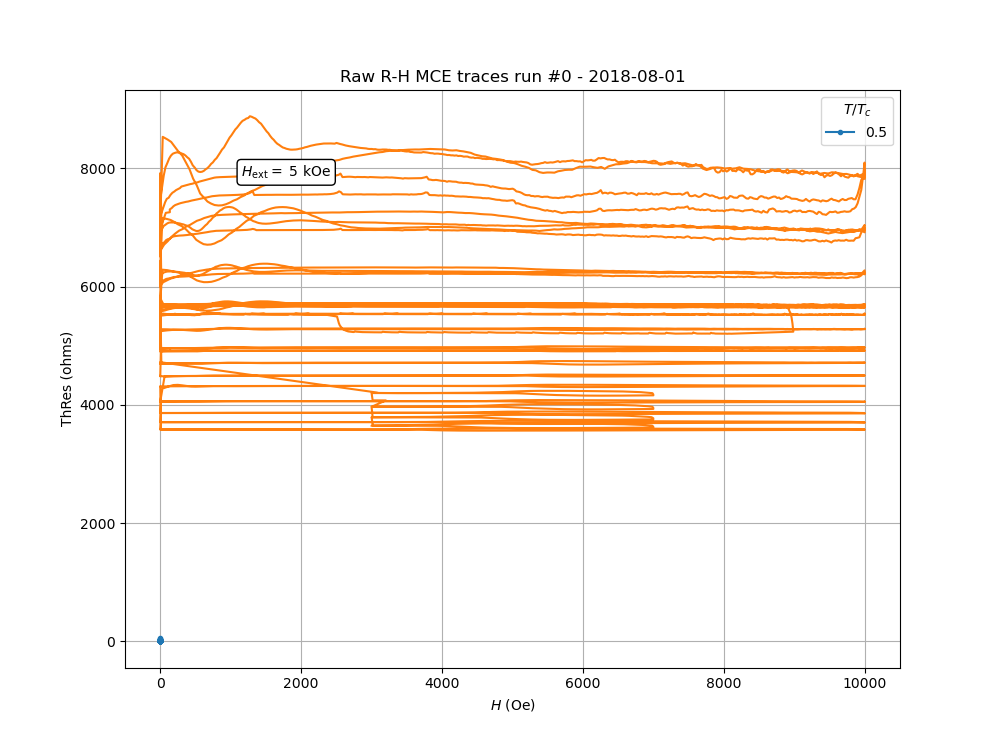

In [14]:
### Plot distribution of fields at a given value of T and Hext
fig, ax = plt.subplots()

plt_keys = {'fixed T': [(uhext[i], utmfd[2])  for i in [0, 2, 4, 6]],
           'fixed H': [(uhext[2], utmfd[i]) for i in [2]]}
# param_index = 1# 0 is constant T, 1 is constant Hext, see param_range
# param_range = [, [i+4*8 for i in [1,3,5,7]]]# first range corresponds to a 
# # field dependence at constant temp, second range corresponds to a 
# # temperature dependence at constant field
# # rng = param_range[param_index]#
Hc = 5e3
Tc = 2.2 
setting = 'fixed H'

if setting=='fixed T':
    fixedp = Tmfd = plt_keys[setting][0][1]
    varp_idx = 0
    pc = Hc
    lgd_title = '$H_{\mathrm{ext}}/H_c$'
    ann_str = f'$T/T_c=$ {Tmfd/Tc:.2g}'
elif setting=='fixed H':
    fixedp = Hext = plt_keys[setting][0][0]
    varp_idx = 1
    pc = Tc
    lgd_title = '$T/T_c$'
    ann_str = ''.join('$H_{\mathrm{ext}} =$' f' {Hext/1e3:.3g} kOe')

for key in plt_keys[setting]:
#     if param_index==0: lgd_str = f'{Hext/Hc:.2g}'
#     elif param_index==1: lgd_str = f'{Tndl/Tc:.2g}'
    lgd_str = f'{key[varp_idx]/pc:.2g}'
    mfd_sel = mfd[key]['hc']==mfd[key]['hc']
#     p = plt.plot(mfd[key]['binCenters'], mfd[key]['hc_nz'], '.-', label=lgd_str)
    p = plt.plot(mfd[key]['binCenters'][mfd_sel], mfd[key]['hc'][mfd_sel], '.-', label=lgd_str)
# plt.xlim([.6966,1.05])

key = (5000,1.1)
# plt.plot(mfd[key]['binCenters'], mfd_model(mfd[key]['binCenters']), label='MFD model')

lgd = plt.legend(title=lgd_title) 
anndist = plt.annotate(ann_str, xy=(.15, .85), xycoords='axes fraction', 
                       bbox=dict(boxstyle='round', fc='w'))# add annotation
# needle_title = 'Field distribution in TmVO$_4$ needles'
# param_title = [f', $T=$ {Tndl:%.2g} K', f', $H_{\mathrm{ext}}=$ {Hext:%.2d} Oe']
# title(''.join([needle_title, param_title[param_index]])
plt.xlabel('$H_{\mathrm{in}}/H_{\mathrm{ext}}$')
plt.ylabel('Probability density')
# plt.xticks = np.arange(.7, 1, .1)
plt.grid(b=True)
cursor()

In [15]:
#%% Compute the average value of ratio of internal to external magnetic field 
for key in mfd.keys():
    mfd[key]['Hinm_Oe'] = np.round(
        np.sum(
        mfd[key]['binCenters']*mfd[key]['hc']*mfd[key]['binWidths']
        )*key[0]
        )
    
    qt = .35# quantile value; proportion of the sample that is below a certain threshold, in values of Hin/Hext
    mfd[key][f'h_quantile_{qt}'] = mfd[key]['binCenters'][np.cumsum(mfd[key]['hc']*mfd[key]['binWidths'])<.35]
#     print(mfd[key]['h_quantile'][-1])# print position of quantile, in values of Hin/Hext

In [16]:
print(mfd[(5000,1.1)][f'h_quantile_{qt}'][-1])

0.926464578313253


In [17]:
#%% Check results for given range of temperatures/field

# Check that the ratio of Hinm/Hext is roughly constant inside the
# ordered phase, thus allowing to use the value at 0.3 K and 1000 Oe as a proxy
for elmt in ['h', 'Hinm', 'Hext', 'Tmfd']:
    exec(f'{elmt}=[]')# initialize lists
    
for key in plt_keys[setting]:
    Tmfd.append(key[1])
    Hext.append(key[0])
    Hinm.append(mfd[key]['Hinm_Oe'])
    h.append(mfd[key]['Hinm_Oe']/key[0])

# rescaling factor, due to demag; take value at H~Hc and T~Tc/2, which is where the MCE data is interesting
# rescaling = mfd[list(mfd)[-6]]['Hinm_Oe']/list(mfd)[-6][0]# used for LS5200 prior to adapting code for LS5228
Href = np.unique(Hext_list)[np.argmin(abs(np.unique(Hext_list)-5000))]
Tref = np.unique(Tmfd_list)[np.argmin(abs(np.unique(Tmfd_list)-1.1))]
rescaling = mfd[(Href,Tref)]['Hinm_Oe']/Href#
rescaling

0.9246

In [18]:
# mfd[(Href,Tref)]['hc'][mfd[(Href,Tref)]['binCenters']<1]
mfd[(5e3,1.1)][f'h_quantile_{qt}'][-1]
# mfd[key]['hc'][hreduced]

0.926464578313253

## Importation of MCE data 

In [19]:
datFilePath = {samples[0]:r'C:\Users\Pierre\Desktop\Postdoc\TmVO4\TmVO4_heat-capacity\2017-07_TmVO4_Cp_MCE\2017-07-28--31\Massaic_MCE',
               samples[1]:r'C:\Users\Pierre\Desktop\Postdoc\TmVO4\TmVO4_heat-capacity\2018-08_TmVO4-LS5228'}
os.chdir(datFilePath[sample])

datafiles = {samples[0]:[f'Run{runID}_*.dat' for runID in range(2,8)],
            samples[1]:['2018-08-01_MCE_TmVO4-LS5228-DR-HC180731.dat']}

In [20]:
# Initialize dictionaries that will contain data for each run
for key in ['dataset', 'timestamp', 'run_date', 'I', 'R', 'H', 'T', 'Tpuck', \
            'Hi', 'Ti', 'Tpucki', 'dtHi','dH', 'dT', 'd1T', 'd2T',\
            'mce_sim', 'mce_fit', 'refsweep', 'usr', 'utbath', 'sweeprates']:
    if key not in locals():
        exec(f'{key}={{}}')

In [21]:
runIDs_all = []
for runID in range(len(datafiles[sample])):
    file_str = glob.glob(datafiles[sample][runID])[0]
    runIDs_all.append(runID)# int(m.group(1)) also works
    if sample==samples[0]:
        m = re.match('Run(\d)_(0p\d).*', file_str)
        I[runID] = float(m.group(2).replace('p','.'))*1e-6# input current, in amps
        dataset[runID] = pd.read_csv(file_str, sep=', ', engine='python')
    elif sample==samples[1]:
        dataset[runID] = pd.read_csv(file_str, sep=',', header=30, engine='python')
        for col in dataset[runID].columns:
            if dataset[runID][col].isna().all():# if a column doesn't contain any data
                dataset[runID].drop(columns=[col], inplace=True)# remove it

print(dataset[runID])

       Time Stamp (sec)  Temperature (K)  Magnetic Field (Oe)  \
0          1.843488e+07         0.974414            57.876705   
1          1.843488e+07         0.949551           121.954155   
2          1.843489e+07         0.960359           185.022614   
3          1.843490e+07         0.990504           248.921677   
4          1.843490e+07         1.007351           311.943329   
...                 ...              ...                  ...   
23608      1.852809e+07         1.700876          3000.310547   
23609      1.852810e+07         1.700578          3000.310547   
23610      1.852810e+07         1.700987          3000.298584   
23611      1.852810e+07         1.700844          3000.322754   
23612      1.852810e+07         1.700840          3000.322754   

       Sample Position (degrees)  Bridge 1 Resistivity (Ohm-m)  \
0                  -1.703913e+38                           NaN   
1                  -1.703913e+38                           NaN   
2                  -1

In [22]:
dataset[0].columns

Index(['Time Stamp (sec)', 'Temperature (K)', 'Magnetic Field (Oe)',
       'Sample Position (degrees)', 'Bridge 1 Resistivity (Ohm-m)',
       'Bridge 1 Excitation (uA)', 'Bridge 2 Resistivity (Ohm-m)',
       'Bridge 2 Excitation (uA)', 'Bridge 1 Std. Dev. (Ohm-m)',
       'Bridge 2 Std. Dev. (Ohm-m)', 'Number of Readings',
       'Bridge 1 Resistance (Ohms)', 'Bridge 2 Resistance (Ohms)'],
      dtype='object')

## Conversion of MCE resistance data to temperature 
using fits of 1/T vs R curves across values of magnetic field and input current

### Reproducing betamodel.mat
Which is the surface fit used in Matlab to convert the platform resistance data of the lockin to inverse temperature data:
$$ 1/T = \mathrm{betamodel}(V_X) $$

In [23]:
# The content of this cell was copy-pasted from the content of the 
# BetaModel sfit variable, as shown in Matlab after importing betamodel.mat

# Coefficients (with 95% confidence bounds):
p00 =     -0.2734#  (-0.2752, -0.2716)
p10 =    9.78e-06#  (8.802e-06, 1.076e-05)
p01 =      0.0011#  (0.001096, 0.001104)
p20 =   -4.45e-09#  (-5.037e-09, -3.862e-09)
p11 =  -1.322e-08#  (-1.427e-08, -1.216e-08)
p02 =  -2.275e-07#  (-2.305e-07, -2.246e-07)
p30 =   9.561e-13#  (7.765e-13, 1.136e-12)
p21 =   3.565e-12#  (3.342e-12, 3.789e-12)
p12 =   4.659e-12#  (4.225e-12, 5.092e-12)
p03 =    3.37e-11#  (3.272e-11, 3.468e-11)
p40 =  -8.502e-17#  (-1.093e-16, -6.072e-17)
p31 =  -6.191e-16#  (-6.464e-16, -5.918e-16)
p22 =   8.508e-17#  (4.041e-17, 1.298e-16)
p13 =  -6.088e-16#  (-6.86e-16, -5.316e-16)
p04 =  -2.724e-15#  (-2.872e-15, -2.577e-15)
p50 =   2.293e-21#  (1.105e-21, 3.48e-21)
p41 =   3.892e-20#  (3.749e-20, 4.034e-20)
p32 =   -1.77e-20#  (-1.973e-20, -1.567e-20)
p23 =   1.698e-21#  (-1.673e-21, 5.069e-21)
p14 =   2.632e-20#  (2.116e-20, 3.148e-20)
p05 =   8.741e-20#  (7.917e-20, 9.565e-20)

# Linear model Poly55:
def betamodel(x,y):
    """
    x: array
        Magnetic field data.
    y: array
        Platform resistance data.
    """
    val = p00 + p10*x + p01*y + p20*x**2 + p11*x*y + p02*y**2 + p30*x**3 +\
    p21*x**2*y + p12*x*y**2 + p03*y**3 + p40*x**4 + p31*x**3*y \
    + p22*x**2*y**2 + p13*x*y**3 + p04*y**4 + p50*x**5 + p41*x**4*y \
    + p32*x**3*y**2 + p23*x**2*y**3 + p14*x*y**4 + p05*y**5
    return val

### Improved R-T conversion scheme
Instead of fitting resistance data stored in the .raw files of Cp measurements, which is what the betamodel function did, fit resistance data directly from the calibration file. This is more accurate for two reasons:
1. There are way more datapoints in the calibration file then in the .raw files of Cp measurements, and they are not redundent
2. The .raw files of Cp measurements use an approximation of the R vs T data taken from the calibration file. Fitting data from the .raw files therefore introduces an extra step (with an extra approximation) in the conversion of data

In [24]:
os.chdir(r'C:\Users\Pierre\Desktop\Postdoc\Technical_stuff\PPMS\PPMS_Heat_capacity\PPMS_Heat-capacity_TempCal')

calname = {samples[0]:'./He3_TempCal/2021-01-15_He3Puck698_multicurve_all_currents.dat',
           samples[1]:'./DR_TempCal/2021-02-02_DR_Tempcal_FisherPPMS/2021-02-02_DRPuck167_multicurve_all_currents.dat'}

calhardware = {samples[0]:'DSP',
               samples[1]:'CAN'}

In [25]:
# Read MFD data from csv file:
# Use last string in header as column header
# Read data from column mfd_idx+2 since, the 3 first columns are x, y, z data
# squeeze=True in order to make it a Series instead of a DataFrame, since there is only one column for each mfd_idx
cal = pd.read_csv(calname[sample], skiprows=7, header=0)
cal

,Temperature (K),Current (code),Active Current Code,Field (Oe),ThRes (ohms),slope of -R vs T (ohms/K),slope of -R vs T (%/K),Point-to-Point R change (ohms),Point-to-Point slope change (ohms/K),Delta R in Overlap (ohms),Delta R in Overlap (%)
0,0.050008,21,21,0.00000,18789.147007,214084.626982,1139.405780,NaN,NaN,NaN,NaN
1,0.050108,21,21,0.00000,18767.777355,213241.084441,1136.208515,-21.369652,843.542541,NaN,NaN
2,0.050208,21,21,0.00000,18746.449295,212401.638238,1133.023299,-21.328060,839.446203,NaN,NaN
3,0.050309,21,21,0.00000,18725.162669,211566.266850,1129.850088,-21.286627,835.371388,NaN,NaN
4,0.050409,21,21,0.00000,18703.917317,210734.948872,1126.688839,-21.245351,831.317978,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
23780,3.962156,13,13,10000.34668,2949.370220,154.049684,5.223138,-1.220237,0.490182,NaN,NaN
23781,3.970080,13,13,10000.34668,2948.151418,153.561634,5.208743,-1.218802,0.488050,NaN,NaN
23782,3.978020,13,13,10000.34668,2946.934045,153.075707,5.194406,-1.217373,0.485927,NaN,NaN
23783,3.985976,13,13,10000.34668,2945.718095,152.591893,5.180125,-1.215950,0.483814,NaN,NaN


In [26]:
cal = cal.iloc[:,:5]
# del cal['Active Current Code']
for cname in cal.columns:
    cal.rename(columns={cname:cname.strip(' ')}, inplace=True)
cal.sort_values('Current (code)', inplace=True, ignore_index=True)
cal

,Temperature (K),Current (code),Active Current Code,Field (Oe),ThRes (ohms)
0,3.993948,13,13,10000.34668,2944.503562
1,3.031613,13,13,50000.20703,3155.533563
2,3.037677,13,13,50000.20703,3153.984568
3,3.043752,13,13,50000.20703,3152.437038
4,3.049840,13,13,50000.20703,3150.891005
...,...,...,...,...,...
23780,0.106819,21,20,50000.20703,12857.820322
23781,0.106606,21,20,50000.20703,12871.807270
23782,0.106393,21,20,50000.20703,12885.804536
23783,0.050203,21,21,30000.31250,18270.988749


In [27]:
if sample==samples[0]:
    codename = './2021-01-19_DSPCurrentCodes.txt'
elif sample==samples[1]:
    codename = './CAN_Current_Codes.txt'
Icodes = pd.read_csv(codename, sep=' ', names=['code', 'current', 'unit'])
Icodes['I (uA)'] = np.where(Icodes['unit']=='nA', Icodes['current']*1e-3,
                            np.where(Icodes['unit']=='mA', Icodes['current']*1e3, 
                                     Icodes['current']))
Icodes.sort_values('code', ignore_index=True)

,code,current,unit,I (uA)
0,0,5.00000,mA,5000.000000
1,1,2.50000,mA,2500.000000
2,2,1.25000,mA,1250.000000
3,3,0.62500,mA,625.000000
4,4,0.31250,mA,312.500000
5,5,0.15625,mA,156.250000
6,6,78.12500,uA,78.125000
7,7,39.06300,uA,39.063000
8,8,19.53100,uA,19.531000
9,9,9.76560,uA,9.765600


In [28]:
dcal = {}
for code in np.unique(cal['Current (code)']):
    dcal[code] = np.where(cal['Current (code)']==code, Icodes['I (uA)'][Icodes['code']==code].item(), 0)
    # .item() returns a Pandas series item value, as opposed to its index
    
cal['I (uA)'] = np.concatenate([dcal[i][dcal[i]>0] for i in np.unique(cal['Current (code)'])])

In [29]:
cal[cal['Current (code)']==13]

,Temperature (K),Current (code),Active Current Code,Field (Oe),ThRes (ohms),I (uA)
0,3.993948,13,13,10000.34668,2944.503562,0.61035
1,3.031613,13,13,50000.20703,3155.533563,0.61035
2,3.037677,13,13,50000.20703,3153.984568,0.61035
3,3.043752,13,13,50000.20703,3152.437038,0.61035
4,3.049840,13,13,50000.20703,3150.891005,0.61035
...,...,...,...,...,...,...
1711,2.866557,13,13,10000.34668,3170.493738,0.61035
1712,2.781921,13,13,10000.34668,3193.612293,0.61035
1713,2.860836,13,13,10000.34668,3172.020596,0.61035
1714,2.855125,13,13,10000.34668,3173.549486,0.61035


In [30]:
maxT = 2
subcal = cal[cal['Temperature (K)']<maxT]
xi = subcal['I (uA)']# current
xm = subcal['Field (Oe)']# magnetic field
z = subcal['Temperature (K)']# temperature
xr = subcal['ThRes (ohms)']# resistance
Xi = np.unique(xi)
Xm = np.arange(0, 1.0e4, 1e2)#
# Xt = np.arange(min(y), maxT, .01)
# Xr = np.arange(7e2, 1.0e4, 1e2)# works for LS5200
Xr = np.arange(np.floor(xr.min()/100)*100, np.ceil(xr.max()/100)*100, 1e2)# more general than the above
# XI, XM, XT = np.meshgrid(Xi, Xm, Xt)  # 3D grid for interpolation
X, Y = np.meshgrid(Xm, Xr)# grid for interpolation
# interp = LinearNDInterpolator(list(zip(xi, xm, xt)), z)
# interp = LinearNDInterpolator(list(zip(xm, xr)), z)
# Z = interp(XI, XM, XT)
# Z = interp(X, Y)

In [31]:
def poly2dcoeffs(pars):
    last = list(pars.keys())[-1]# parameter with highest indices
    kx, ky = int(last[1]), int(last[2])# order of 2d polynomial
    coeffs = np.empty((kx+1,ky+1))# initialize array of coefficients

    parvals = pars.valuesdict()
    for paridx, (i,j) in enumerate(np.ndindex(kx+1,ky+1)):
        coeffs[i,j] = list(parvals.values())[paridx]
    
    return coeffs

def poly2dres(pars, x, y, z):
    return polyval2d(x, y, poly2dcoeffs(pars))-z

In [32]:
params = Parameters()
for (i,j) in np.ndindex(5,5):
    params.add(name=f'c{i}{j}', value=1)

result = minimize(poly2dres, params, args=(xm, xr, 1/z))
result.redchi

0.043907781927597624

In [33]:
Z = polyval2d(X, Y, poly2dcoeffs(result.params))

<IPython.core.display.Javascript object>


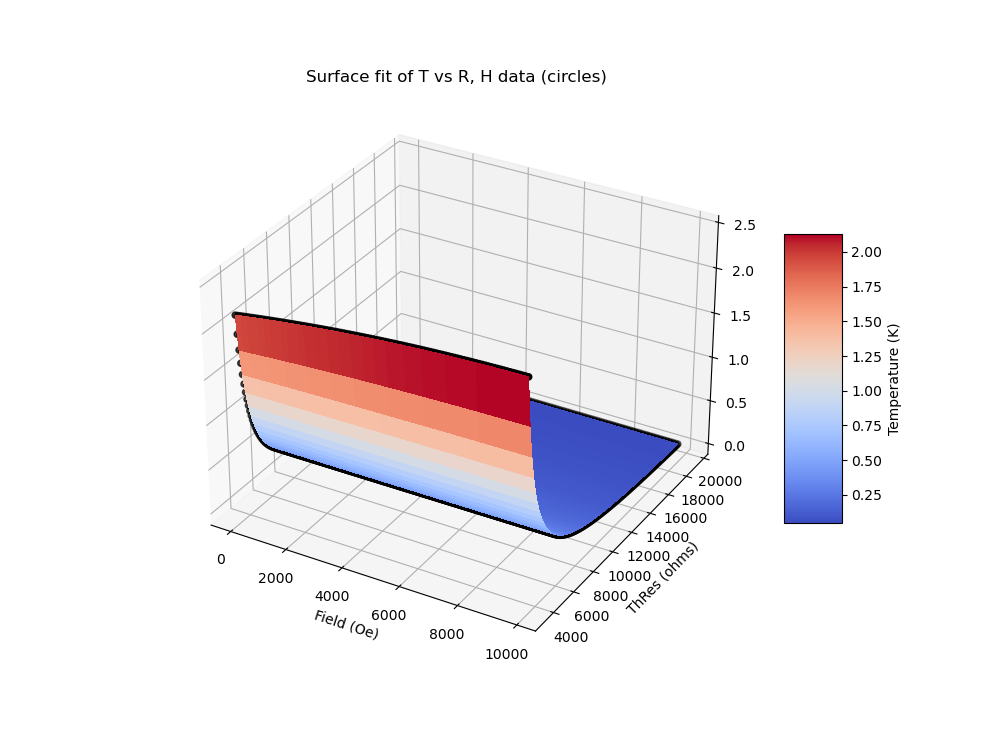

Text(0.5, 0.92, 'Surface fit of T vs R, H data (circles)')

In [34]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(X, Y, 1/Z, c='k', marker='o')# make sure Z doesn't go through zero
surf = ax.plot_surface(X, Y, 1/Z, cmap=cm.coolwarm, rcount=100,
                       linewidth=0, antialiased=False)
# surf = ax.contour3D(X, Y, 1/Z, 50, cmap='viridis')
# Add a color bar which maps values to colors.
cb = fig.colorbar(surf, shrink=0.5, aspect=5)
# plt.xlim(right=1e4)
plt.xlabel(xm.name)
plt.ylabel(xr.name)
cb.set_label(z.name)
plt.title('Surface fit of T vs R, H data (circles)')

### Convert and store MCE data into dictionaries
Resistance data obtained from the voltage data $V_X$ of the X channel of the lock-in amplifier and the input electrical current $I$ as:
$$ R_\mathrm{platform} = V_X / I $$
Temperature data obtained from resistance data using the above polynomial fit

In [35]:
xlabel_mce = '$H$ (Oe)'
ylabel_mce = '$T + \Delta T_\mathrm{MCE}$ (K)'
# title_mce = f'MCE traces run {runID} - {run_date[runID]}'

In [36]:
# Store columns containing data of magnetic field, puck temperature, and resistance into variables
for runID in runIDs_all:
    if sample==samples[0]:
        Hi[runID] = {'raw':dataset[runID]['Field(T)']*1e4} # Magnetic field, in Oersted
        Hi[runID]['raw'].rename('Field (Oe)', inplace=True)
        Tpucki[runID] = {'raw':dataset[runID]['Temperature(K)']}# Puck (bath) temperature, in Kelvin
        R[runID] = dataset[runID]['LockinX(V)']/I[runID]# Platform resistance, in Volts
        run_date[runID] = re.match('.* (\d+/\d+/20\d{2}) .*', dataset[runID].columns[5]).group(1)
        timestamp[runID] = dataset[runID]['Time']
    elif sample==samples[1]:
        # First remove rows containing negative values of resistance (unphysical)
        dataset[runID].drop(index=dataset[runID][dataset[runID]['Bridge 2 Resistance (Ohms)']<0].index.tolist(), inplace=True)
        # Then store data
        Hi[runID] = {'raw':dataset[runID]['Magnetic Field (Oe)']} # Magnetic field, in Oersted
        Tpucki[runID] = {'raw':dataset[runID]['Temperature (K)']}# Puck (bath) temperature, in Kelvin
        R[runID] = dataset[runID]['Bridge 2 Resistance (Ohms)']# Platform resistance, in Volts
        run_date[runID] = '2018-08-01'
        timestamp[runID] = dataset[runID]['Time Stamp (sec)']
        
#     Ti[runID] = {'raw':1/betamodel(Hi[runID]['raw'], R[runID])}
    Ti[runID] = {'raw':1/polyval2d(Hi[runID]['raw'], R[runID], poly2dcoeffs(result.params))}
#     temp = np.empty(R[runID].shape)
#     for ridx, rval in enumerate(R[runID]):
#         hcol = np.argmin(abs(Hi[runID]['raw'].iloc[ridx]-Xm))
#         rrow = np.argmin(abs(rval-Xr))
#         temp[ridx] = Z[rrow, hcol]
#     Ti[runID] = {'raw':pd.Series(temp)}

<IPython.core.display.Javascript object>


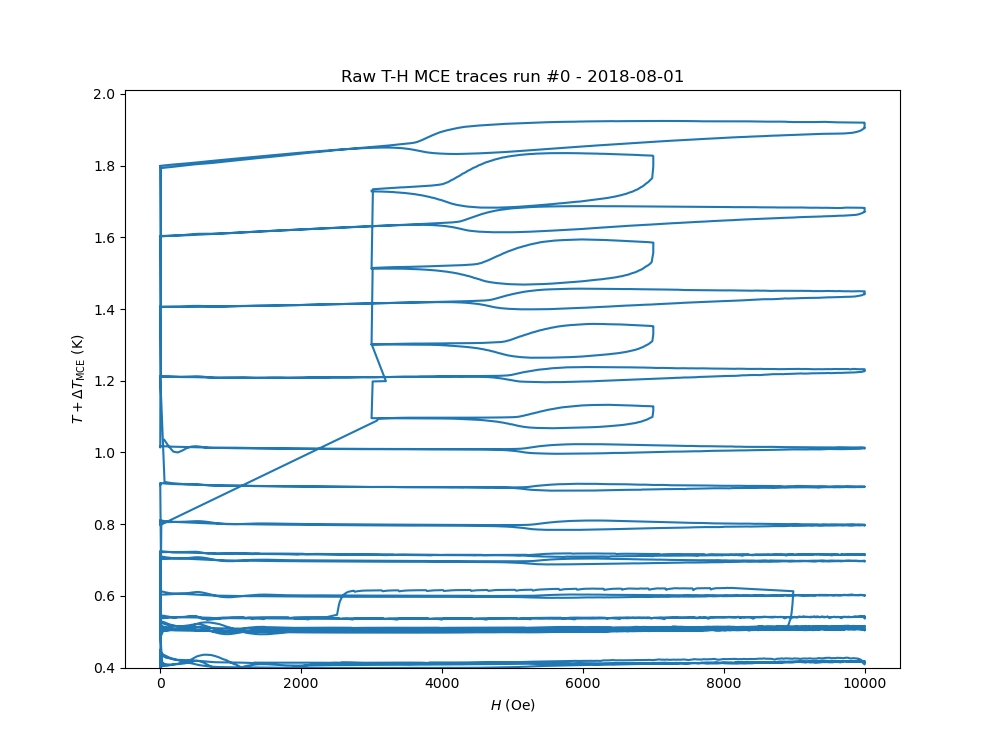

In [37]:
# Raw MCE traces
# runID = 6
pltIDs = {samples[0]:[2], samples[1]:[0]}
for pltID in pltIDs[sample]:#runIDs_all[:]:
    plt.figure(num=pltID*10)
#     plt.plot(Hi[pltID]['raw'], Ti[pltID]['raw'])
    plt.plot(Hi[pltID]['raw'], Ti[pltID]['raw'])
    plt.ylim(bottom=0.4)
    plt.xlabel(xlabel_mce)
    plt.ylabel(ylabel_mce)
    plt.title(f'Raw T-H MCE traces run #{pltID} - {run_date[pltID]}')

In [38]:
# %matplotlib
# Raw MCE traces
# runID = 6
for pltID in pltIDs[sample]:#pltIDs_all[:]:
    plt.figure(num=pltID*10+1)
#     plt.plot(Hi[pltID]['raw'], Ti[pltID]['raw'])
    plt.plot(Hi[pltID]['raw'], R[pltID])
#     plt.ylim(bottom=0)
    plt.xlabel(xlabel_mce)
    plt.ylabel(xr.name)
    plt.title(f'Raw R-H MCE traces run #{pltID} - {run_date[pltID]}')

## Smooth MCE data

In [39]:
for runID in runIDs_all:
    for el in [Hi, Ti]:
        el[runID]['smoothed'] = gaussian_filter1d(el[runID]['raw'], 1)
        el[runID]['sssmooth'] = gaussian_filter1d(el[runID]['raw'], 5)

<IPython.core.display.Javascript object>


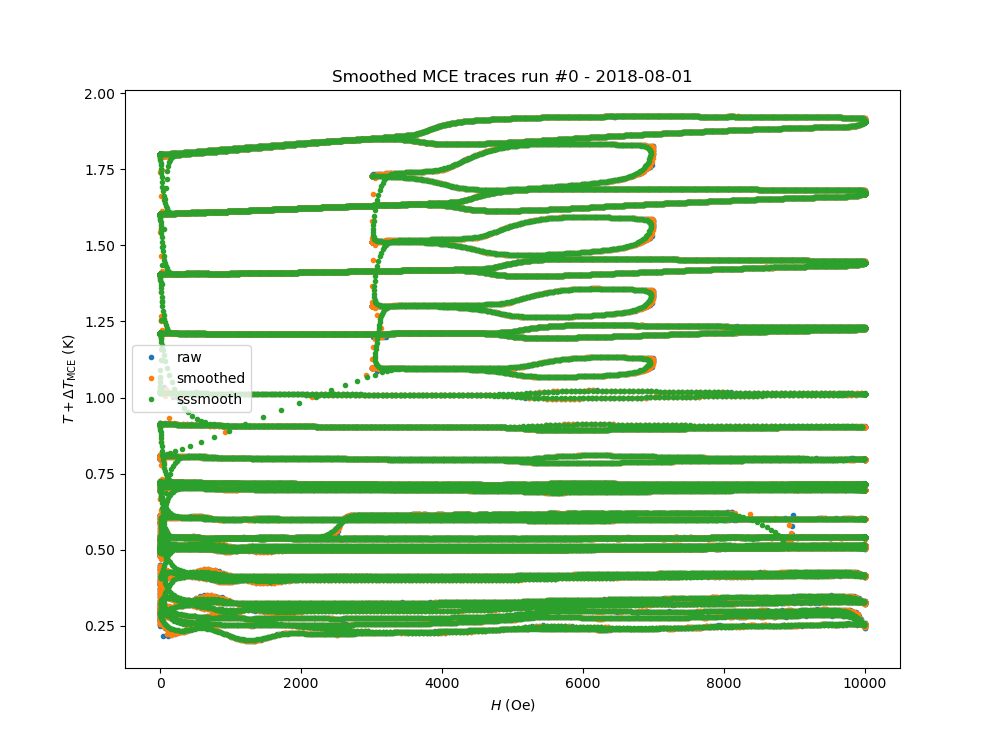

In [40]:
# %matplotlib
# Smoothed MCE traces
for runID in pltIDs[sample]:#runIDs_all:
    plt.figure(num=runID+10)
    labels = ['raw', 'smoothed', 'sssmooth']
    for lbl in labels:
        plt.plot(Hi[runID][lbl], Ti[runID][lbl], '.', label=lbl)
#     plt.ylim(bottom=0.4)
    plt.xlabel(xlabel_mce)
    plt.ylabel(ylabel_mce)
    plt.title(f'Smoothed MCE traces run #{runID} - {run_date[runID]}')
    plt.legend()

In [41]:
pltIDs

{'TmVO4-LS5200': [2], 'TmVO4-LS5228-DR-HC1807': [0]}

## Determine the magnetic field sweep rates used in the measurement

In [42]:
# Compute dtH data and extract sweeprates from it
for var in ['cdh', 'udh', 'sweeprates_all']:
    exec(f'{var}={{}}')

for runID in runIDs_all:
    dtHi[runID] = np.diff(Hi[runID]['smoothed'])/np.diff(timestamp[runID])
#     dT[runID] = pd.Series(np.diff(Ti[runID]['smoothed']))
#     d1T[runID] = dT[runID][dtH[runID]>0]/dtH[runID][dtH[runID]>0]
    udh[runID], cdh[runID] = np.unique(np.round(dtHi[runID]), return_counts=True)
    refcdh = {samples[0]:250, samples[1]:50}# best value to eliminate datapoints that are not actual traces
    sweeprates_all[runID] = udh[runID][np.logical_and(cdh[runID]>refcdh[sample], udh[runID]!=0)]

dtHi[runID]#[d1T[runID].idxmax()]

array([ 6.49184249e+00,  9.37618739e+00,  9.95167210e+00, ...,
       -4.71534858e-05,  4.94994199e-03,  4.24126302e-03])

In [43]:
class DataError(Exception):
    """Customized errors for the purpose of MCE data analysis."""
    def __init__(self, message):
        self.message = message

In [44]:
# Function to separate traces based on sweeprate
def sep_sweeprates(sweeprates, dtH, X):
    Xout = {}
    
    if len(sweeprates)<1:
        raise DataError("No value of sweeprate was stored for this run.")
    elif len(sweeprates)==1:
        sr = sweeprates[0]
        Xout[sr] = pd.Series(X)
    else:
        # Combine sweep rates that are close enough to one another
        csr = 0# This variable increments as long as a sweeprate differs from the previous one by just 1 Oe/s
        for ir, sr in enumerate(sweeprates):
            if ir<csr:
                continue
            elif ir<len(sweeprates)-1:
                csr = ir + 1
                while abs(sweeprates[csr]-sweeprates[csr-1])==1:
                    csr = csr+1
                    if csr>=len(sweeprates):
                        break

            # Filter data based on sweep rate
            if ir==0:                        
                refsweep = np.mean([sweeprates[csr-1], sweeprates[csr]])
                out = X[dtH<refsweep]
            elif ir<len(sweeprates)-1 and csr<len(sweeprates):
                rsm = np.mean([sr, sweeprates[ir-1]])
                rsp = np.mean([sweeprates[csr-1], sweeprates[csr]])
                out = X[np.logical_and(dtH<rsp, dtH>rsm)]
            else:
                refsweep = np.mean([sr, sweeprates[ir-1]])
                out = X[dtH>refsweep]
            
            # Select sweep rate value to store based on parity
            # if there is an even number of sweep rates, store the middle one
            if (csr-ir) % 2 == 1:
                fr = ir + (csr-ir-1)//2#
            # otherwise store the one corresponding to a sweep rate of even parity
            elif sweeprates[(csr+ir)//2] % 2 == 0:
                fr = (csr+ir)//2
            else:
                fr = (csr+ir)//2-1
            Xout[sweeprates[fr]] = pd.Series(out)

    return Xout

In [45]:
# Compute H, T, Tpuck
for runID in runIDs_all:
    for pq in [(Hi, H), (Ti, T), (Tpucki, Tpuck)]:# pq stands for physical quantity
#         # Initialize dictionaries to store data
#         if runID not in pq[0].keys():
#             pq[0][runID] = {}
#         if 'dict' not in pq[0][runID].keys():
        pq[0][runID]['dict'] = {}# create/reset dictionary
        pq[1][runID] = pd.DataFrame()# create/reset dataFrame
            
        # Reduce length of reference arrays by 1, since dtH has 1 element less than these
        try:
            Xm = np.mean([pq[0][runID]['smoothed'][:-1], pq[0][runID]['smoothed'][1:]], 0)
        except KeyError:
            Xm = np.mean([pq[0][runID]['raw'][:-1], pq[0][runID]['raw'][1:]], 0)
        
        pq[0][runID]['dict'] = sep_sweeprates(sweeprates_all[runID], dtHi[runID], Xm)

        # Concatenate separated data into a single DataFrame, for each run
        try:
            pq[1][runID] = pd.concat(pq[0][runID]['dict'], axis=1)# 0 was chosen as key for simplicity
        except ValueError:
            warn(f"Concatenation failed for data of run #{runID}.")
            break

In [46]:
# Compute dtH, dT
for runID in runIDs_all:
    sweeprates[runID] = np.asarray(H[runID].columns)
    usr[runID], csr = np.unique(abs(sweeprates[runID]), return_counts=True)

    for el in [Hi, Ti]:
        el[runID]['sssmooth'] = gaussian_filter1d(el[runID]['raw'], 50/max(abs(sweeprates[runID])))

    dTm = np.diff(Ti[runID]['smoothed'])
    dHm = np.diff(Hi[runID]['smoothed'])#dtHi[runID]
    dTd = sep_sweeprates(sweeprates_all[runID], dtHi[runID], dTm)
    dHd = sep_sweeprates(sweeprates_all[runID], dtHi[runID], dHm)

    for pq in [(dHd, dH), (dTd, dT)]:# pq stands for physical quantity
        pq[1][runID] = pd.DataFrame()# create/reset dataFrame
        # Concatenate separated data into a single DataFrame, for each run
        try:
            pq[1][runID] = pd.concat(pq[0], axis=1)# 0 was chosen as key for simplicity
        except ValueError:
            warn(f"Concatenation failed for data of run #{runID}.")
            break
            
    dHfilter = abs(dH[runID])>0
    d1T[runID] = dT[runID][dHfilter]/dH[runID][dHfilter]


<IPython.core.display.Javascript object>


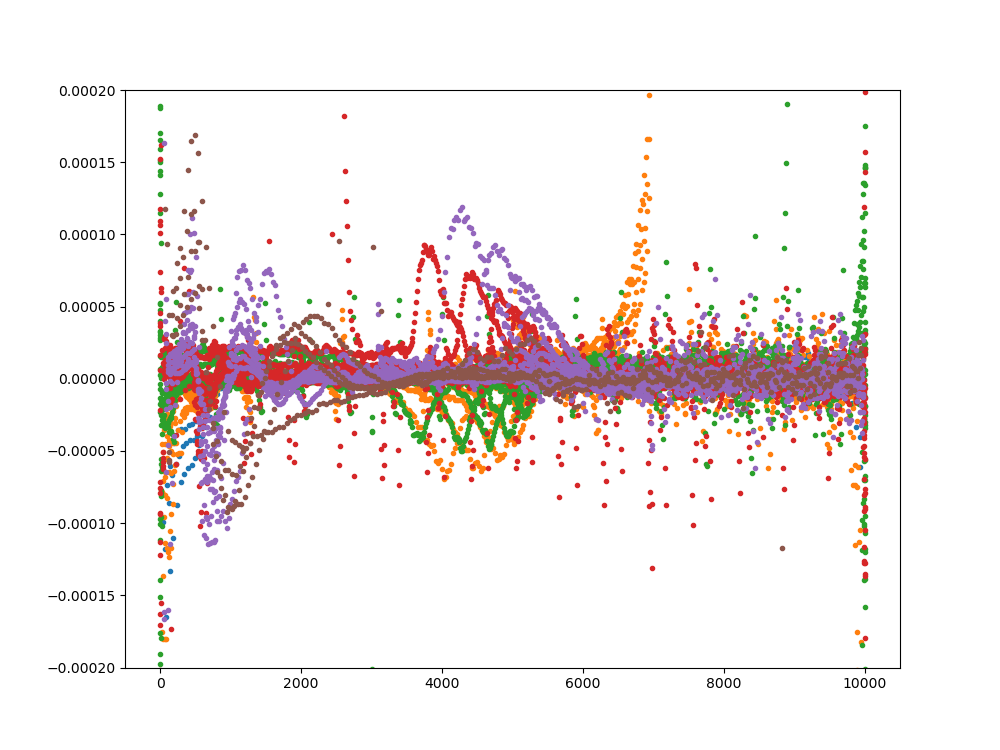

(-0.0002, 0.0002)

In [47]:
plt.figure()
# plt.plot(np.diff(Hi[runID]['smoothed']))
# plt.plot(np.diff(Hi[runID]['sssmooth']))
plt.plot(H[runID],d1T[runID], '.')
plt.ylim(2e-4*np.array([-1,1]))

<IPython.core.display.Javascript object>


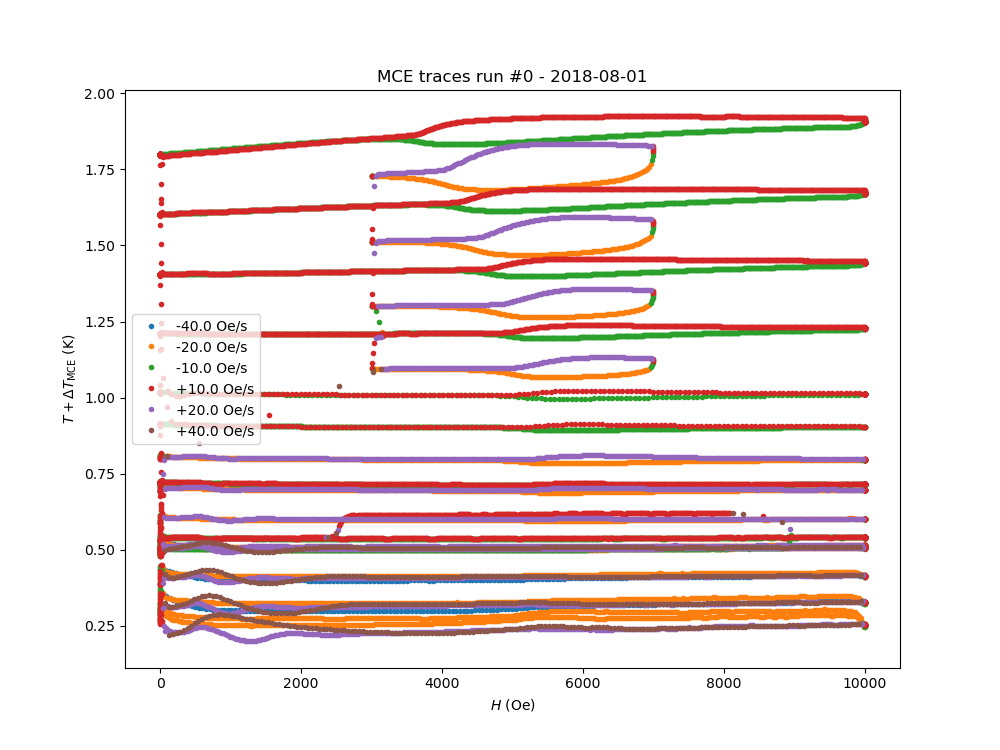

In [48]:
# import ipywidgets as widgets
for runID in runIDs_all:
    fig = plt.figure()
    for i, sr in enumerate(H[runID].columns):
        plt.plot(H[runID][sr], T[runID][sr], '.', label=f'{sr:+.1f} Oe/s')
#     plt.ylim(bottom=0.4)
    plt.xlabel(xlabel_mce)
    plt.ylabel(ylabel_mce)
    plt.title(f'MCE traces run #{runID} - {run_date[runID]}')
    plt.legend()

In [49]:
# Create generator of runIDs, excluding run #6 which is bad
runIDs = [x for x in runIDs_all if x!=6]

In [50]:
# Identify values of bath temperature used for the measurements
npoints = 250
for runID in runIDs:
    # ut, ct = np.unique(np.round(Tpucki[runID]['raw'], 2), return_counts=True)# Use raw data
    ut, ct = np.unique(np.round(Tpuck[runID], 1), return_counts=True)# Same, by construction of Tpuck[runID]

    # Show counts for each value of bath temperature, ignoring NaN
    print(runID, [[ut[ct>npoints][i], ct[ct>npoints][i]] for i in range(len(ut[ct>npoints]))])
    utbath[runID] = ut[ct>npoints]# select only those values that occur in more than 500 data points
utbath[runID]#

0 [[0.2, 1374], [0.3, 1226], [0.4, 1211], [0.5, 4968], [0.6, 813], [0.7, 2468], [0.8, 802], [0.9, 998], [1.0, 635], [1.1, 320], [1.2, 1860], [1.3, 323], [1.4, 2003], [1.5, 322], [1.6, 2002], [1.7, 322], [1.8, 1964]]


array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4,
       1.5, 1.6, 1.7, 1.8])

In [51]:
# Test bath_temp function
sr = sweeprates[runID][1]
for Tb in utbath[runID][:1]:
    dataFilter = np.logical_and(np.logical_and(H[runID][sr]>10, H[runID][sr]<4e3),
                                np.round(Tpuck[runID][sr], 1)==Tb)
    # print(min(dTp), max(dTp))
    Hp = H[runID][sr][dataFilter]
    Tp = T[runID][sr][dataFilter]
    Tb = mce.bath_temp([Tp], rel_temp_bound=1e-3, timeit=True)
    print(Tb)

Runtime of bath_temp function: 0.0013 seconds
0.26503640243068377


## Effect of MFD on critical field Hc
See how the critical field moves when including a field distribution

The array of magnetic fields is chosen such that the result of the convolution with the magnetic field distribution is consistent with the MFD: if the MFD spans a range $R$ of Hin/Hext and has $N$ bins, then the step size at field $H_\mathrm{ref}$ should be:
$$ \delta H = H_\mathrm{ref} \cdot \frac{R}{N} $$
Taking $R \sim 0.75$ (from ~0.65 to ~1.4, see section [Comsol magnetic field distribution](#mfd)), $N=75$, and $H_\mathrm{ref} = 5000$ Oe, the result is $\delta H = 50$ Oe.
Ideally the range of fields should scale with the field, but that's complicated and not very important since what we care about is what happens around the critical field, i.e. around 5 kOe.

### Upsweep

In [54]:
# print(datFilePath[sample] + f'\{str(today)[:-3]}_{sample}_MCE_analysis')
os.chdir(datFilePath[sample] + f'\{str(today)[:-3]}_{sample}_MCE_analysis')
print(os.getcwd())

C:\Users\Pierre\Desktop\Postdoc\TmVO4\TmVO4_heat-capacity\2018-08_TmVO4-LS5228\2021-05_TmVO4-LS5228-DR-HC1807_MCE_analysis


#### Consistency between MFD and data fitting
A good fit of the data requires a field array with a step of 40 Oe or more, which leads to a ratio of $\frac{H_c^{\mathrm{real}}}{H_c^{\mathrm{measured}}}$ < 0.8. This is inconsistent with the magnetic field distribution computed in Comsol, which shows that the magnetic field inside the bulk of the sample is > 0.9 $ \cdot H_{\mathrm{ext}}$. In fact, since the peak of the MFD occurs at a value of $h \equiv \frac{H_{\mathrm{in}}}{H_{\mathrm{ext}}} \approx 0.975$ (see section [Plot of MFD](#mfd)), the onset of the measured MCE should be at $H_c^{\mathrm{measured}}\approx \frac{H_c^{\mathrm{real}}}{0.975} \Rightarrow \Delta H_c \equiv H_c^{\mathrm{measured}}-H_c^{\mathrm{real}} \approx 0.025 \cdot H_c^{\mathrm{measured}}$.
This constrains the stepsize $\delta H$ of the field array used for the numerical convolution between the MFD and the theoretical curve in the absence of MFD: $\Delta H_c = N_p \times \delta H$, where $N_p$ is the number of points in the MFD between 1 and 0.975 (where it peaks). With a stepsize of 1/binf = $10^{-3}$ for the MFD, $N_p = \frac{1-0.975}{10^{-3}} = 25$.
Hence $\delta H = \frac{\Delta H_c}{N_p} \approx 10^{-3} \cdot H_c^{\mathrm{measured}}\approx 5$ Oe.

However, with a stepsize of 5 Oe, the resulting curve does not fit the data well. 
The best compromise seems to be obtained for a field array with a step of 10 Oe, where the shape of the curve matches the data reasonably well. 
The issue is that the critical field as determined from the max of the second derivative is overestimated, as compared to that extracted from the experimental data. However the positions of the max of the first derivatives seem to match. Hence, compute the ratios Hc_real/H[max(1st derivative)]  and then applied it to the data to determine the Hc_real in the sample vs temperature.

#### To do as of 2021-04-29
* Compute hc=Hin/Hext vs Tbath for sweeprates of +-10 Oe/s and +-20 Oe/s. When using a field stepsize of 5 Oe, take the max of the second derivative of MCE as Hc. If using a field stepsize of 10 Oe, take max of first derivative. But does it make sense to do that latter computation??
* Extract Hc from experimental data, and apply hc factor. If hc was computed for fields with both stepsizes, compare results.
* Save results in csv file, then import in Origin, plot phase diagram, fit with Rafael's predictions, etc.
Note: the code below is not finished and may yield errors.

In [118]:
Tx[dHa][10].keys()
Tx[dHa][10][1.2]

{'homogeneous': 0        1.213044
 1        1.213044
 2        1.213044
 3        1.213044
 4        1.213044
            ...   
 12995    1.213086
 12996    1.213085
 12997    1.213085
 12998    1.213088
 12999    1.213086
 Length: 13000, dtype: float64,
 'mfd': 0        0.002138
 1        0.002201
 2        0.002201
 3        0.002201
 4        0.002406
            ...   
 12995    1.211010
 12996    1.211010
 12997    1.211010
 12998    1.210963
 12999    1.210962
 Length: 13000, dtype: float64}

#### Compute simulated MCE without and with demagnetizing fields, for the two relevant magnetic field sweep rates, and for two relevant field step sizes, i.e. convolution steps
Also compute the corresponding first and second derivatives wrt magnetic field, and deduce the ratios of critical fields without and with demag

In [64]:
if 'Tx' not in locals():
    Tx = {}
    d1Tx = {}
    d2Tx = {}
    Hcup = {}
    hc = {}

mfd_key = (5000,1.1)

dHa = 5# field step determines the splitting between the 'real' and measured critical fields, see above
Ha = np.arange(-50*binf, 1.5e4, dHa)# array of fields; see section intro
Hsel = np.logical_and(Ha>2e3, Ha<9e3)

if dHa not in Tx.keys():
    Tx[dHa] = {}
    d1Tx[dHa] = {}
    d2Tx[dHa] = {}
    Hcup[dHa] = {}
    hc[dHa] = {}


for sra in [10, 20]:
    if sra not in Tx[dHa].keys():
        Tx[dHa][sra] = {}
        d1Tx[dHa][sra] = {}
        d2Tx[dHa][sra] = {}
        Hcup[dHa][sra] = {}
        hc[dHa][sra] = {}

    for temp in (round(0.1*x,1) for x in range(7,19)):
        if temp in Tx[dHa][sra].keys(): 
            print(f'{temp} in Tx[dHa][sra].keys(): {temp in Tx[dHa][sra].keys()}')
            continue

        dataFilter = data_filter(H[runID][sra], Tpuck[runID][sra], Hmin=1e3, Hmax=9.9e3, Tbath=temp)
        Hf = H[runID][sra][dataFilter]
        Tf = T[runID][sra][dataFilter]

        try:
            Tb = Tf.iloc[(Hf-4e3).abs().argsort()].iloc[0]# temperature at H = 4e3 Oe
        except IndexError: continue

        print(f'Field step: {dHa} Oe; Bath temperature: {temp} K')

        # Initialize dicts
        Tx[dHa][sra][temp] = {}
        d1Tx[dHa][sra][temp] = {}
        d2Tx[dHa][sra][temp] = {}
        Hcup[dHa][sra][temp] = {}
        hc[dHa][sra][temp] = {}

        # MCE in the absence of a magnetic field distribution
        real_Hc0 = 5e3
        Hc0 = real_Hc0
        real_kappa = .15*Tb
        prms = mce.mce_parameters(Hc0=Hc0, sweeprate=sra, kappa=real_kappa*real_Hc0/Hc0, Tc0=2.2, Tbath=Tb)
        Tx[dHa][sra][temp]['homogeneous'] = pd.Series(mce.mce_residual(prms, Ha, trace='upsweep'))

        # MCE in the presence of a magnetic field distribution
        Tx[dHa][sra][temp]['mfd'] = pd.Series(convolve(Tx[dHa][sra][temp]['homogeneous'], mfd[mfd_key]['hc'][::-1], mode='same')\
                                   /sum(mfd[mfd_key]['hc']))
        # Tx[dHa][sra]['mfd'][~Hsel] = Tx[dHa][sra]['homogeneous'][~Hsel]
        
        # compute ratio of critical fields without and with demag
        for label in ['homogeneous', 'mfd']:
            d1Tx[dHa][sra][temp][label] = Tx[dHa][sra][temp][label].diff()
            d2Tx[dHa][sra][temp][label] = d1Tx[dHa][sra][temp][label].diff()
            if dHa==5:
                Hcup[dHa][sra][temp][label] = Ha[d2Tx[dHa][sra][temp][label][Hsel].idxmax()]
            elif dHa==10:
                Hcup[dHa][sra][temp][label] = Ha[d1Tx[dHa][sra][temp][label][Hsel].idxmax()]
            print(f'Hcup[{dHa}][{sra}][{label}] = {Hcup[dHa][sra][temp][label]}')

        hc[dHa][sra][temp] = Hcup[dHa][sra][temp]['homogeneous']/Hcup[dHa][sra][temp]['mfd']
        print(f"{hc[dHa][sra][temp]:.3f}\n")#

    if dHa==5:
        shref = f"MFD ratio Hin/Hext = {mfd[mfd_key]['binCenters'][mfd[mfd_key]['hc'].argmax()]:.3f}\n"
    elif dHa==10:
        shref = f"MFD ratio Hin/Hext = {mfd[mfd_key]['h_quantile_0.35'][-1]:.3f}\n"
    print(shref)# value of the ratio Hin/Hext which has the highest probability in the sample

Field step: 5 Oe; Bath temperature: 0.7 K
Duration of ODE solving = 24.077
Hcup[5][10][homogeneous] = 4985.0
Hcup[5][10][mfd] = 5145.0
0.969

Field step: 5 Oe; Bath temperature: 0.9 K
Duration of ODE solving = 1.536
Hcup[5][10][homogeneous] = 4925.0
Hcup[5][10][mfd] = 5085.0
0.969

Field step: 5 Oe; Bath temperature: 1.0 K


C:\Users\Pierre\Desktop\Postdoc\Software\Python\Python_scripts\MCE_analysis_Python\MCE_simulations\mce_w_demag.py:114: RuntimeWarning: overflow encountered in square
  return y/t + k * (y/t)**2 * np.cosh(t/y)**2 * (yb - y)
C:\Users\Pierre\Desktop\Postdoc\Software\Python\Python_scripts\MCE_analysis_Python\MCE_simulations\mce_w_demag.py:114: RuntimeWarning: invalid value encountered in add
  return y/t + k * (y/t)**2 * np.cosh(t/y)**2 * (yb - y)


Duration of ODE solving = 0.648
Hcup[5][10][homogeneous] = 4860.0
Hcup[5][10][mfd] = 5020.0
0.968

Field step: 5 Oe; Bath temperature: 1.1 K
Duration of ODE solving = 0.350
Hcup[5][10][homogeneous] = 4780.0
Hcup[5][10][mfd] = 4940.0
0.968

Field step: 5 Oe; Bath temperature: 1.2 K
Duration of ODE solving = 0.219
Hcup[5][10][homogeneous] = 4680.0
Hcup[5][10][mfd] = 4840.0
0.967

Field step: 5 Oe; Bath temperature: 1.3 K
Duration of ODE solving = 0.171
Hcup[5][10][homogeneous] = 4575.0
Hcup[5][10][mfd] = 4735.0
0.966

Field step: 5 Oe; Bath temperature: 1.4 K
Duration of ODE solving = 0.139
Hcup[5][10][homogeneous] = 4375.0
Hcup[5][10][mfd] = 4535.0
0.965

Field step: 5 Oe; Bath temperature: 1.5 K
Duration of ODE solving = 0.142
Hcup[5][10][homogeneous] = 4120.0
Hcup[5][10][mfd] = 4280.0
0.963

Field step: 5 Oe; Bath temperature: 1.6 K
Duration of ODE solving = 0.181
Hcup[5][10][homogeneous] = 3855.0
Hcup[5][10][mfd] = 4015.0
0.960

Field step: 5 Oe; Bath temperature: 1.7 K
Duration of O

C:\Users\Pierre\Desktop\Postdoc\Software\Python\Python_scripts\MCE_analysis_Python\MCE_simulations\mce_w_demag.py:114: RuntimeWarning: overflow encountered in multiply
  return y/t + k * (y/t)**2 * np.cosh(t/y)**2 * (yb - y)


Duration of ODE solving = 0.537
Hcup[5][10][homogeneous] = 2975.0
Hcup[5][10][mfd] = 3135.0
0.949

MFD ratio Hin/Hext = 0.968

Field step: 5 Oe; Bath temperature: 0.7 K
Duration of ODE solving = 17.213
Hcup[5][20][homogeneous] = 4985.0
Hcup[5][20][mfd] = 5145.0
0.969

Field step: 5 Oe; Bath temperature: 0.8 K
Duration of ODE solving = 2.918
Hcup[5][20][homogeneous] = 4965.0
Hcup[5][20][mfd] = 5125.0
0.969

Field step: 5 Oe; Bath temperature: 1.1 K
Duration of ODE solving = 0.164
Hcup[5][20][homogeneous] = 4795.0
Hcup[5][20][mfd] = 4955.0
0.968

Field step: 5 Oe; Bath temperature: 1.2 K
Duration of ODE solving = 0.119
Hcup[5][20][homogeneous] = 4695.0
Hcup[5][20][mfd] = 4855.0
0.967

Field step: 5 Oe; Bath temperature: 1.3 K
Duration of ODE solving = 0.110
Hcup[5][20][homogeneous] = 4560.0
Hcup[5][20][mfd] = 4720.0
0.966

Field step: 5 Oe; Bath temperature: 1.5 K


C:\Users\Pierre\Desktop\Postdoc\Software\Python\Python_scripts\MCE_analysis_Python\MCE_simulations\mce_w_demag.py:114: RuntimeWarning: overflow encountered in multiply
  return y/t + k * (y/t)**2 * np.cosh(t/y)**2 * (yb - y)


Duration of ODE solving = 0.060
Hcup[5][20][homogeneous] = 4180.0
Hcup[5][20][mfd] = 4340.0
0.963

Field step: 5 Oe; Bath temperature: 1.7 K
Duration of ODE solving = 0.159
Hcup[5][20][homogeneous] = 3420.0
Hcup[5][20][mfd] = 3580.0
0.955

MFD ratio Hin/Hext = 0.968



#### Incorporated in above cell as of 2021-05-12

#### Plot simulated MCE

<IPython.core.display.Javascript object>


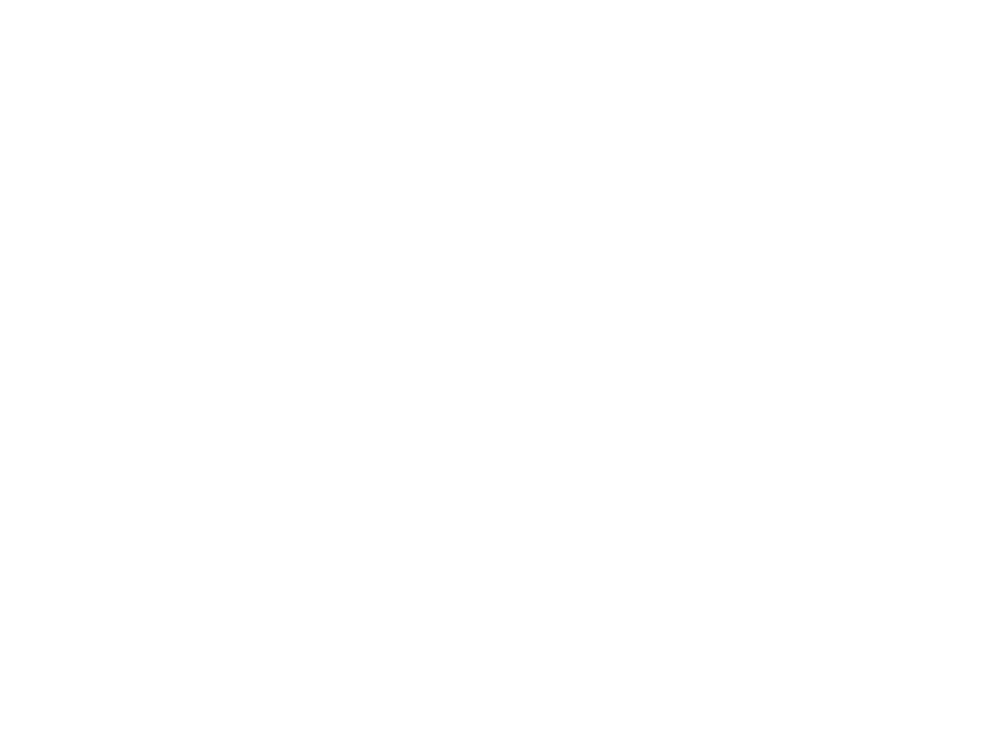

In [167]:
dHa = 10
sra = 10
temp = 1.4
dataFilter = data_filter(H[runID][sra], Tpuck[runID][sra], Hmin=1e3, Hmax=9.9e3, Tbath=temp)
Hf = H[runID][sra][dataFilter]
Tf = T[runID][sra][dataFilter]

# Plot the calculated MCE
fig, ax = plt.subplots()
plt.plot(Hf, Tf, '.', label='data')

Ha = np.arange(-50*binf, 1.5e4, dHa)# array of fields; see section intro
scaledHa = Ha*real_Hc0/Hc0
Hsel = np.logical_and(scaledHa>0, scaledHa<9.99e3)

plt.plot(scaledHa[Hsel], Tx[dHa][sra][temp]['homogeneous'][Hsel], label='sim no mfd')
plt.plot(scaledHa[Hsel], Tx[dHa][sra][temp]['mfd'][Hsel], label='sim w/ mfd')

# for binf in mfd_test.keys():
#     Tx[binf] = pd.Series(convolve(Tx[dHa][sra][temp]['homogeneous'], mfd_test[binf][::-1], mode='same')\
#                          /sum(mfd_test[binf]))
#     plt.plot(Ha[Hsel], Tx[binf][Hsel], label=f'mfd {binf:.0e} bins')

# plt.ylim(bottom=.49)
plt.title(''.join(['Experimental vs simulated MCE curves\n',
           f'Sweep rate {sra} Oe/s']))
plt.xlabel(r'$H$ (Oe)')
plt.ylabel(r'$T$ (K)')
anndist = plt.annotate(''.join([r'$\kappa_{\mathrm{fit}} =$', f'{real_kappa:.2g} W/m/K']), 
                       xy=(.15, .85), xycoords='axes fraction', 
                       bbox=dict(boxstyle='round', fc='w'))# add annotation
plt.legend()
cursor()

#### Irrelevant as of 2021-05-12

In [381]:
for sra in [10]:
    der_sel = Tx[sra][label]>Tx[sra][label].loc[Ha==1000].iloc[0]
    # Compute derivatives of MCE and the resulting critical field
    for label in ['homogeneous', 'mfd']:
        d1Tx[sra][label] = Tx[sra][label][der_sel].diff()
        d2Tx[sra][label] = d1Tx[sra][label].diff()
        Hcup[sra][label] = Ha[d2Tx[sra][label][np.logical_and(Hsel, der_sel)].idxmax()-1]
        print(f'Hcup[sra][{label}] = {Hcup[sra][label]}')

    hc = {'up':Hcup[sra]['homogeneous']/Hcup[sra]['mfd']}
    print(f"{hc['up']:.3f}")#
    print(f"{mfd[mfd_key]['binCenters'][mfd[mfd_key]['hc'].argmax()]:.3f}\n")# value of the ratio Hin/Hext which has the highest probability in the sample


Hcup[sra][homogeneous] = 9987.0
Hcup[sra][mfd] = 4850.0
2.059
0.969



<IPython.core.display.Javascript object>


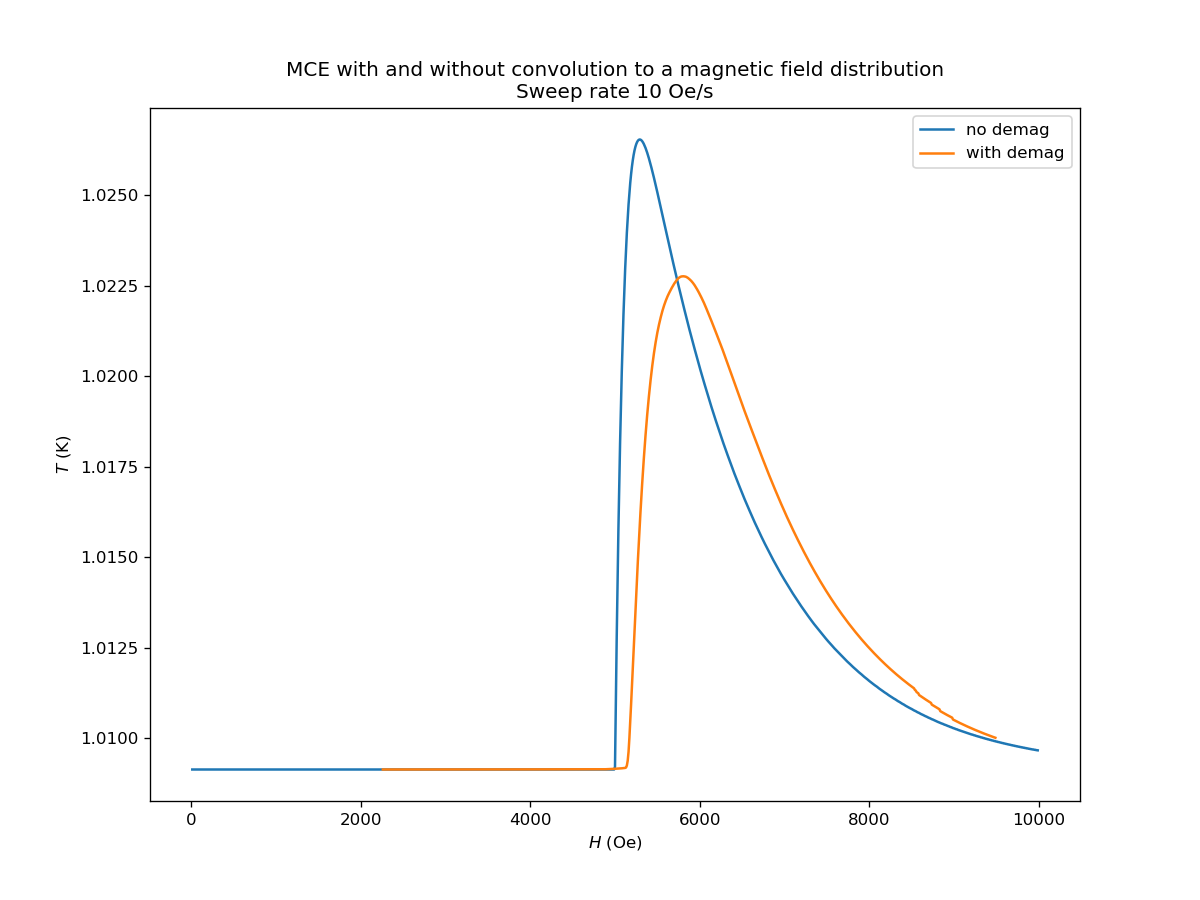

In [130]:
# Plot the calculated MCE
fig, ax = plt.subplots()
plt.plot(Ha, Tx[sra]['homogeneous'], label='no demag')
    
plt.plot(Ha[Hsel], Tx[sra]['mfd'][Hsel], label='with demag')
# plt.ylim(bottom=.49)
plt.title(''.join(['MCE with and without convolution to a magnetic field distribution\n',
           f'Sweep rate {sra} Oe/s']))
plt.xlabel(r'$H$ (Oe)')
plt.ylabel(r'$T$ (K)')
plt.legend()
cursor()

In [51]:
# plt.savefig(f'{str(today)}_TmVO4-LS5228-DR-HC180731_MCE_sim_40Oeps.png', bbox_inches='tight', dpi=200)

#### Conclusion as of 2021-04
The fact that the ratios of critical fields without and with demag is about equal to the most probable ratio of internal to external fields in the sample is an important result, which shows two things for the MCE when sweeping magnetic field *upwards*:

1. The second derivative is a good choice for determining the critical field in the upsweep traces of MCE
2. The ratio between the actual critical field, and the one observed in the presence of demagnetizing fields, corresponds quite precisely to the highest ratio of Hin/Hext found in the sample (with non-negligible probability), which in this case is the ratio of Hin/Hext that has the highest probability density, due to the asymmetry of the MFD. This is expected, since the temperature changes as soon as a non-negligible part of the sample experiences a field equal or higher than the critical field, when field is swept up.

It is also important to note that this ratio does not seem to depend on the magnetic field sweep rate, nor on temperature.

### Downsweep

C:\Users\Pierre\Desktop\Postdoc\Software\Python\Python_scripts\MCE_analysis_Python\MCE_simulations\mce_w_demag.py:125: RuntimeWarning: overflow encountered in multiply
  return y/t + k * (y/t)**2 * np.cosh(t/y)**2 * (yb - y)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\integrate\_ivp\rk.py:109: RuntimeWarning: invalid value encountered in true_divide
  return norm(self._estimate_error(K, h) / scale)


Bath temperature: 0.5 K; sweep rate: -40.0 Oe/s
Hc = 5020 Oe, T(Hc) = 0.496 K
Hc = 5410 Oe, T(Hc) = 0.498 K
H_c{no_demag}/H_c{with_demag} = 0.928

Bath temperature: 0.6 K; sweep rate: -40.0 Oe/s
Hc = 5010 Oe, T(Hc) = 0.589 K
Hc = 5410 Oe, T(Hc) = 0.593 K
H_c{no_demag}/H_c{with_demag} = 0.926

Bath temperature: 0.7 K; sweep rate: -40.0 Oe/s
Hc = 5010 Oe, T(Hc) = 0.676 K
Hc = 5410 Oe, T(Hc) = 0.683 K
H_c{no_demag}/H_c{with_demag} = 0.926

Bath temperature: 0.8 K; sweep rate: -40.0 Oe/s
Hc = 5000 Oe, T(Hc) = 0.759 K
Hc = 5400 Oe, T(Hc) = 0.768 K
H_c{no_demag}/H_c{with_demag} = 0.926

Bath temperature: 0.9 K; sweep rate: -40.0 Oe/s
Hc = 5000 Oe, T(Hc) = 0.838 K
Hc = 5390 Oe, T(Hc) = 0.849 K
H_c{no_demag}/H_c{with_demag} = 0.928

Bath temperature: 1.0 K; sweep rate: -40.0 Oe/s
Hc = 5000 Oe, T(Hc) = 0.914 K
Hc = 5380 Oe, T(Hc) = 0.928 K
H_c{no_demag}/H_c{with_demag} = 0.929

Bath temperature: 1.1 K; sweep rate: -40.0 Oe/s
Hc = 5000 Oe, T(Hc) = 0.989 K
Hc = 5380 Oe, T(Hc) = 1.004 K
H_c{no_dem

C:\Users\Pierre\Desktop\Postdoc\Software\Python\Python_scripts\MCE_analysis_Python\MCE_simulations\mce_w_demag.py:125: RuntimeWarning: overflow encountered in square
  return y/t + k * (y/t)**2 * np.cosh(t/y)**2 * (yb - y)


Bath temperature: 0.5 K; sweep rate: -10.0 Oe/s
Hc = 5000 Oe, T(Hc) = 0.499 K
Hc = 5410 Oe, T(Hc) = 0.500 K
H_c{no_demag}/H_c{with_demag} = 0.924

Bath temperature: 0.6 K; sweep rate: -10.0 Oe/s
Hc = 5000 Oe, T(Hc) = 0.597 K
Hc = 5420 Oe, T(Hc) = 0.598 K
H_c{no_demag}/H_c{with_demag} = 0.923

Bath temperature: 0.7 K; sweep rate: -10.0 Oe/s
Hc = 5010 Oe, T(Hc) = 0.692 K
Hc = 5530 Oe, T(Hc) = 0.695 K
H_c{no_demag}/H_c{with_demag} = 0.906

Bath temperature: 0.8 K; sweep rate: -10.0 Oe/s
Hc = 5000 Oe, T(Hc) = 0.786 K
Hc = 5560 Oe, T(Hc) = 0.791 K
H_c{no_demag}/H_c{with_demag} = 0.899

Bath temperature: 0.9 K; sweep rate: -10.0 Oe/s
Hc = 5000 Oe, T(Hc) = 0.878 K
Hc = 5580 Oe, T(Hc) = 0.884 K
H_c{no_demag}/H_c{with_demag} = 0.896

Bath temperature: 1.0 K; sweep rate: -10.0 Oe/s
Hc = 5000 Oe, T(Hc) = 0.969 K
Hc = 5590 Oe, T(Hc) = 0.977 K
H_c{no_demag}/H_c{with_demag} = 0.894

Bath temperature: 1.1 K; sweep rate: -10.0 Oe/s
Hc = 5000 Oe, T(Hc) = 1.059 K
Hc = 5600 Oe, T(Hc) = 1.068 K
H_c{no_dem

<IPython.core.display.Javascript object>


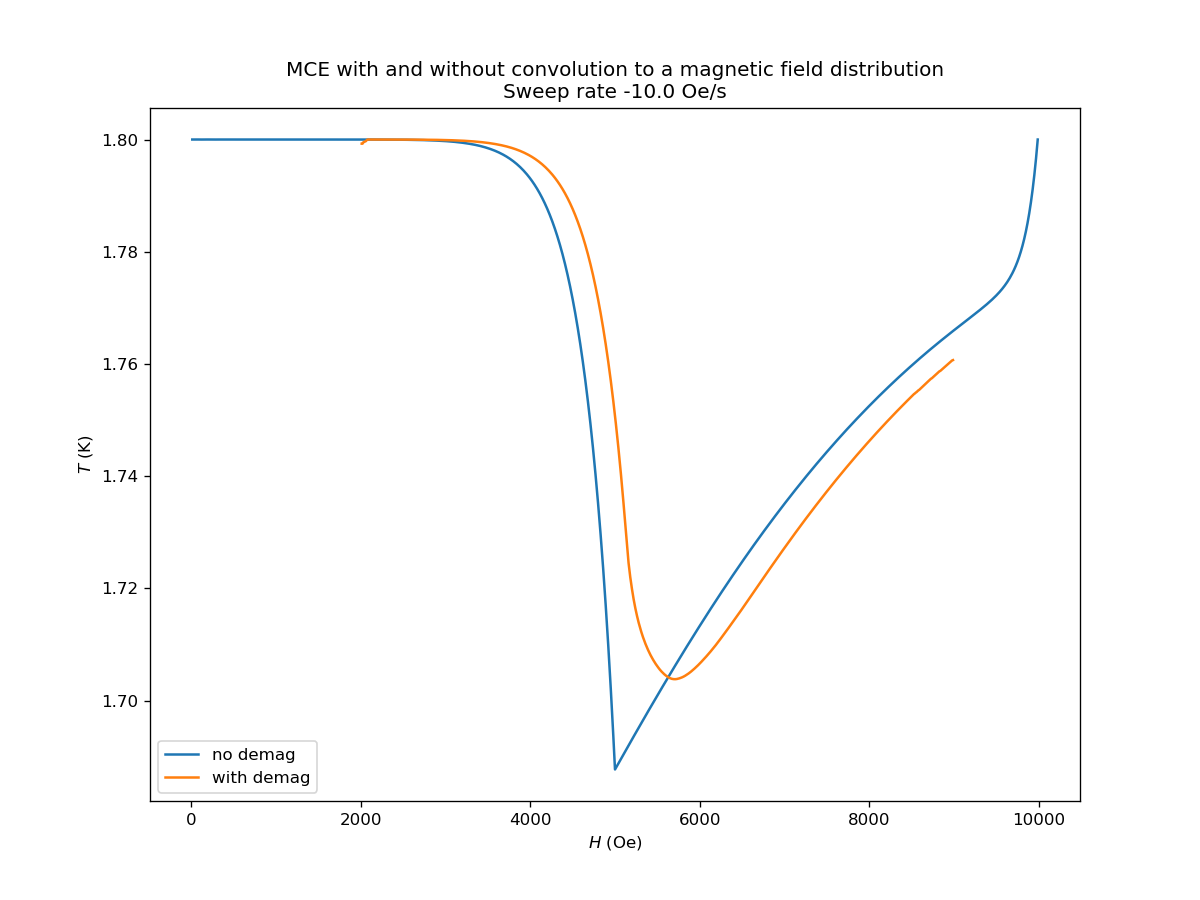

In [52]:
# Compute theoretical MCE with and without demag
hc['down'] = {}
Tb_range = np.arange(.5,1.9,.1)
for key in sweeprates.keys():
    for sra in iter(sweeprates[key][sweeprates[key]<0]):
        hc[sra] = {}
        for Temp in Tb_range:
            Tb = round(Temp,1)
            prms = mce.mce_parameters(Hc=5e3, sweeprate=sra, Tc0=2.2, Tbath=Tb)

            # MCE in the absence of a magnetic field distribution
            Tx['homogeneous'] = pd.Series(mce.mce_residual(prms, Ha, trace='downsweep'))

            # MCE in the presence of a magnetic field distribution
            Tx['mfd'] = pd.Series(convolve(Tx['homogeneous'], mfd[mfd_key]['hc'][::-1], mode='same')/sum(mfd[mfd_key]['hc']))

            Hcdn = {}
            Hsel = np.logical_and(Ha>2e3, Ha<9e3)

            print(f'Bath temperature: {Tb} K; sweep rate: {sra} Oe/s')
            # Store value of critical field as position of the temperature minimum
            for label in ['homogeneous', 'mfd']:
                Hcdn[label] = Ha[Tx[label][Hsel].idxmin()]
                print(f'Hc = {Hcdn[label]:.0f} Oe, T(Hc) = {Tx[label][Tx[label][Hsel].idxmin()]:.3f} K')

            if np.round(Hcdn['homogeneous'],-2)!=5e3: continue# ignore computational aberrations

            hc[sra][Tb] = Hcdn['homogeneous']/Hcdn['mfd']
            print(f"H_c{{no_demag}}/H_c{{with_demag}} = {hc[sra][Tb]:.3f}\n")#

fig, ax = plt.subplots()
plt.plot(Ha, Tx['homogeneous'], label='no demag')
    
plt.plot(Ha[Hsel], Tx['mfd'][Hsel], label='with demag')
# plt.ylim(bottom=.49)
plt.title(''.join(['MCE with and without convolution to a magnetic field distribution\n',
           f'Sweep rate {sra} Oe/s']))
plt.xlabel(r'$H$ (Oe)')
plt.ylabel(r'$T$ (K)')
plt.legend()
cursor()

In [53]:
# Find and delete inconsistent computational results
for sr_key in hc['down'].keys():
    # loop over temperature keys in *reverse* order, since the length of the dictionary is going to change
    for temp_key, hc_val in sorted(list(hc['down'][sr_key].items()), reverse=True):
        if temp_key<.7: 
            continue
        else:
            for diff in [-.1,.1]:
                try:
                    if hc_val>1.01*hc['down'][sr_key][round(temp_key+diff,1)]:
                        del hc['down'][sr_key][temp_key]
                        break
                except KeyError:
                    continue

In [54]:
hc#['down']

{'up': 0.9689922480620154,
 'down': {-40.0: {0.5: 0.9279112754158965,
   0.6: 0.9260628465804066,
   0.7: 0.9260628465804066,
   0.8: 0.9259259259259259,
   0.9: 0.9276437847866419,
   1.0: 0.929368029739777,
   1.1: 0.929368029739777,
   1.3: 0.9276437847866419,
   1.4: 0.9276437847866419,
   1.5: 0.9259259259259259,
   1.6: 0.9242144177449169,
   1.7: 0.922509225092251,
   1.8: 0.9191176470588235},
  -20.0: {0.5: 0.9242144177449169,
   0.6: 0.9243542435424354,
   0.7: 0.9157509157509157,
   0.8: 0.9124087591240876,
   0.9: 0.9124087591240876,
   1.0: 0.9124087591240876,
   1.1: 0.9107468123861566,
   1.2: 0.9090909090909091,
   1.4: 0.9041591320072333,
   1.5: 0.9025270758122743,
   1.6: 0.8992805755395683,
   1.7: 0.8960573476702509,
   1.8: 0.8928571428571429},
  -10.0: {0.5: 0.9242144177449169,
   0.6: 0.922509225092251,
   0.7: 0.9059674502712477,
   0.8: 0.8992805755395683,
   0.9: 0.8960573476702509,
   1.0: 0.8944543828264758,
   1.1: 0.8928571428571429,
   1.2: 0.889679715302

<IPython.core.display.Javascript object>


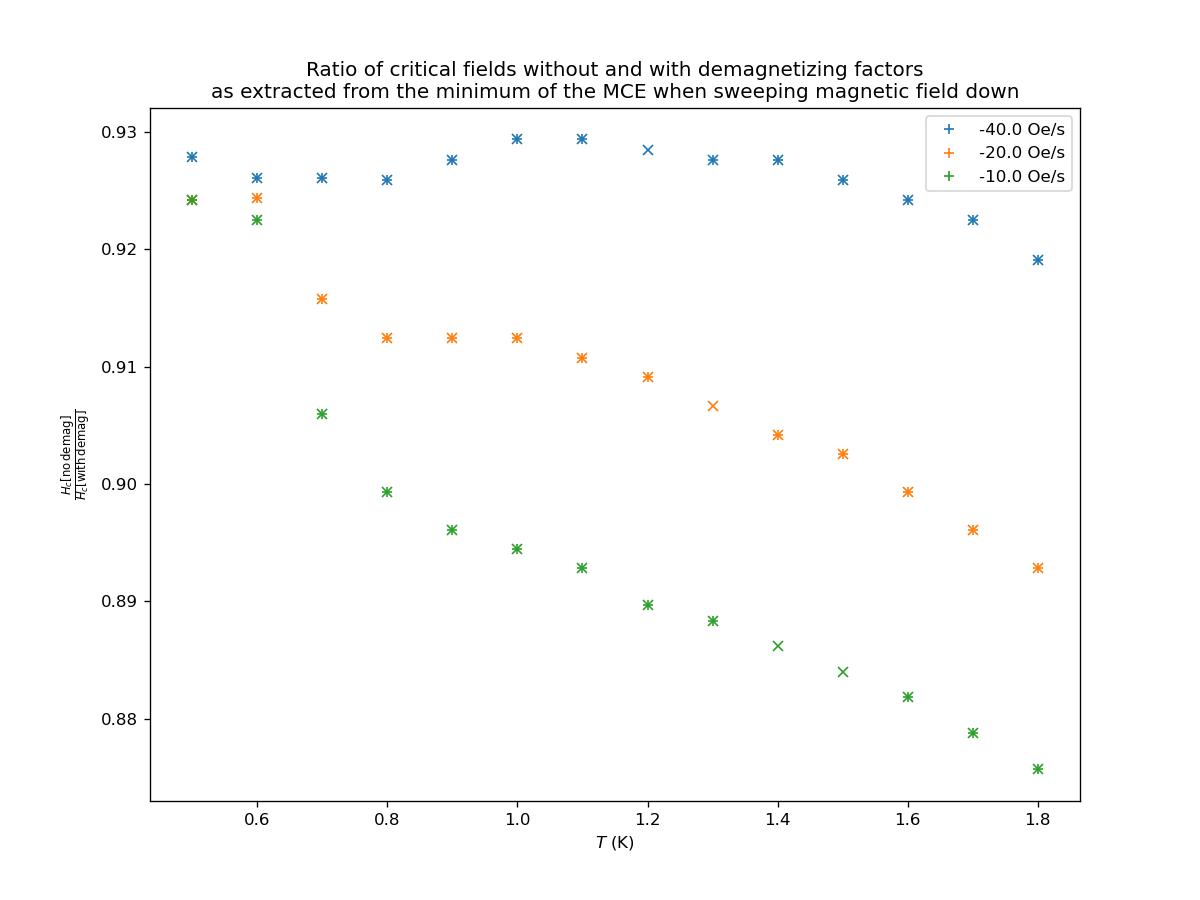

In [55]:
# Plot results vs temperature
plt.figure(figsize=[10,7.5])
for idx, sra in enumerate(hc['down'].keys()):
    # Plot results of computation
    x,y = zip(*hc[sra].items())
    plt.plot(x, y, '+', color=f'C{idx}', label=f'{sra} Oe/s')
    # Interpolate deleted datapoints
    f = interp1d(*zip(*hc[sra].items()))
    for temp in Tb_range:
        Tb = round(temp,1)
        if Tb not in hc[sra].keys():
            hc[sra][Tb] = float(f(Tb))
    plt.plot(*zip(*hc[sra].items()), 'x', color=f'C{idx}', label='')
plt.xlabel(r'$T$ (K)')
plt.ylabel(r'$\frac{H_c[\mathrm{no\, demag}]}{H_c[\mathrm{with\, demag}]}$')
plt.title('Ratio of critical fields without and with demagnetizing factors\n\
as extracted from the minimum of the MCE when sweeping magnetic field down')
plt.legend()

In [56]:
os.chdir(datFilePath[sample] + r'\Extracted_critical_fields\Hc_ratios_vs_temperature')
print(os.getcwd())

C:\Users\Pierre\Desktop\Postdoc\TmVO4\TmVO4_heat-capacity\2018-08_TmVO4-LS5228\Extracted_critical_fields\Hc_ratios_vs_temperature


##### Conclusion
The critical field cannot be determined as easily from the MCE downsweep data as for the upsweep data:
when sweeping magnetic field downwards in a real sample (with demagnetizing fields), the position of the minimum (or whichever feature is used to determine the critical field) with respect to the intrinsic critical field, varies with sweep rate and temperature. 
For the sweep rate, this is because the parts of the sample that experience a field lower than the critical field thermally relax, so the faster the field is swept down, the larger part of the sample reaches the critical field before the thermal relaxation becomes significant.
For the temperature dependence, it stems from the the fact that the second term in the RHS of the MCE equation becomes larger as temperature decreases (due to the $\cosh ^2\left(\frac{T_{c0}}{T} \cdot \frac{H}{H_{c0}}\right) $ factor), thus better compensating the thermal relaxation than at higher temperatures.

#### Next steps as of 2021-04-22
* Overlay numerical curves of MCE on top of data to check the validity of the above approach
* Use the dictionary of numerically-computed ratios $\frac{H_c^\mathrm{down}(\mathrm{no-demag})} {H_c^\mathrm{down}(\mathrm{with-demag})}$ to extract values of critical fields from the data

##### Attempts at understanding the ratio of $H_c^\mathrm{down}$ without and with demag
These were attempts at explaining why the ratio of $H_c^\mathrm{down}$ without and with demag is so low for a sweeprate of -10 Oe/s, but it does not work and is too complicated: let's just use the result of the above numerical computation.

## Compute second derivative of data

### Plot 1st and 2nd derivatives of data on top of one another

In [73]:
H[runID]

,-40.0,-20.0,-10.0,10.0,20.0,40.0
0,9927.836638,9937.700922,10000.326673,105.582837,2352.600514,2384.801845
1,9878.278555,9910.398608,10000.311193,155.754651,2525.690643,2493.496807
2,9825.494973,9884.161633,10000.328037,217.115917,8942.127086,8131.700188
3,9772.349531,9858.451308,10000.314668,280.438993,60.739728,8270.062199
4,9719.827548,9833.110362,10000.301723,343.893188,87.391747,8824.205903
...,...,...,...,...,...,...
7631,NaN,NaN,3005.221445,NaN,NaN,NaN
7632,NaN,NaN,3001.104169,NaN,NaN,NaN
7633,NaN,NaN,3000.375013,NaN,NaN,NaN
7634,NaN,NaN,3000.314094,NaN,NaN,NaN


<IPython.core.display.Javascript object>


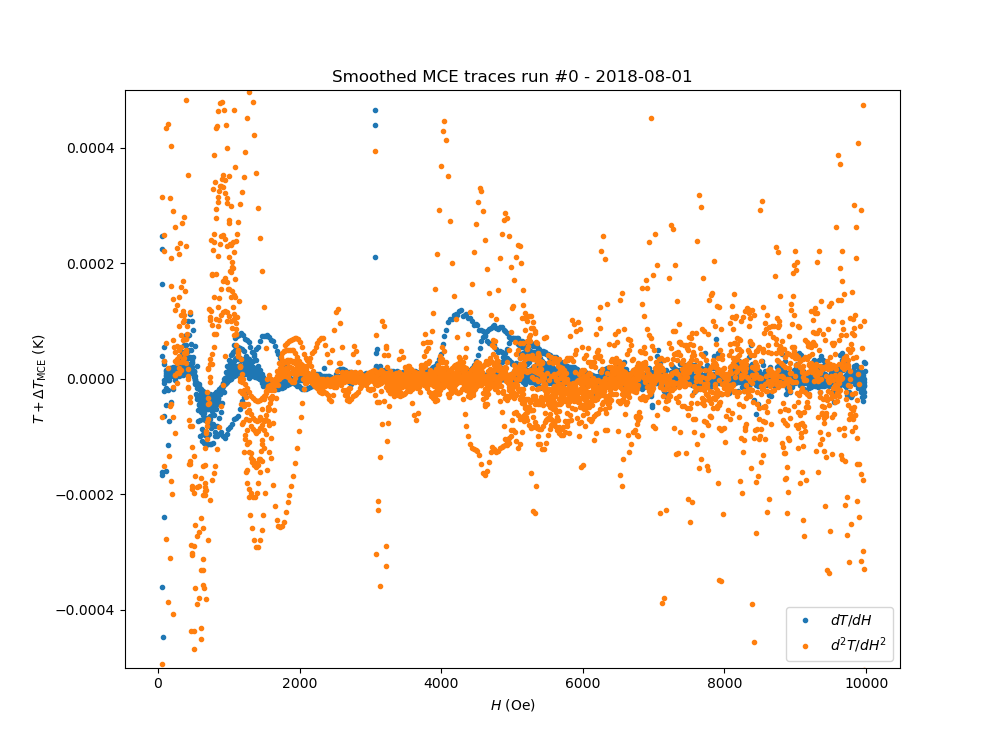

In [69]:
pltIDs = [0]
sr = 20
runID = 0
d1Ttest = {}
d1Ttest[sr] = pd.Series(gaussian_filter1d(d1T[runID][sr], 2))
for runID in pltIDs:#runIDs:
    plt.figure()
    plt.plot(H[runID][sr], d1T[runID][sr], '.', label=r'$dT/dH$')
    plt.plot(H[runID][sr], d1Ttest[sr].diff()/dH[runID][sr]*1e3, '.', label=r'$d^2T/dH^2$')
#     plt.ylim(bottom=0.4)
    plt.xlabel(xlabel_mce)
    plt.ylabel(ylabel_mce)
    plt.title(f'Smoothed MCE traces run #{runID} - {run_date[runID]}')
    plt.ylim(np.arange(-1, 2, 2)*5e-4)
    plt.legend()

### Extract critical fields 

In [101]:
Tbref = {samples[0]:0.4, samples[1]:0.5}
for elmt in ['d2T', 'd2Tdf', 'HTc', 'HTcd1', 'HTcd2', 'HTcmin', 'dHc']:
    exec(f'{elmt} = {{}}')
    
for runID in runIDs[:]:
    for elmt in ['d2T', 'd2Tdf', 'HTc', 'HTcd1', 'HTcd2', 'HTcmin', 'dHc']:
        exec(f'{elmt}[runID] = {{}}')
    for sr in sweeprates[runID][:]:
        for elmt in ['d2Tdf', 'HTc', 'HTcd1', 'HTcd2', 'HTcmin', 'dHc']:
            exec(f'{elmt}[runID][sr] = {{}}')

        for Tb in utbath[runID][:]:
            if Tb<=Tbref[sample]: continue

            dataFilter = data_filter(H[runID][sr], Tpuck[runID][sr], Hmin=3.5e3, Hmax=5.75e3, Tbath=Tb)
            Hf = H[runID][sr][dataFilter]
            Tf = T[runID][sr][dataFilter]

            try:
                dp_spacing = round(np.mean(dH[runID][sr][dataFilter]))
            except ValueError:
                continue

            Nsmth = 2#
            d1Tgauss = pd.Series(gaussian_filter1d(d1T[runID][sr], Nsmth))
            d2T[runID][sr] = d1Tgauss.diff()/dH[runID][sr]
            d1Tf = d1T[runID][sr][dataFilter]
            d2Tf = d2T[runID][sr][dataFilter]
            
            try:
                # Save values of critical field; 
                # it seems that .idxmax() is systematically shifted by 1 index ??
                # for the 2nd derivative, hence the .idxmax()-1
                # HTcd1[runID][sr][Tb] = (Hf[abs(d1Tf).idxmax()], Tf[abs(d1Tf).idxmax()])
                HTcd1[runID][sr][Tb] = (Hf[d1Tf.idxmax()], Tf[d1Tf.idxmax()])
                HTcd2[runID][sr][Tb] = (Hf[d2Tf.idxmax()-1], Tf[d2Tf.idxmax()-1])
                HTcmin[runID][sr][Tb] = (Hf[Tf.idxmin()], Tf.min())
                if sr>0:
                    HTc[runID][sr][Tb] = HTcd2[runID][sr][Tb]
                elif sr<0:
                    HTc[runID][sr][Tb] = HTcmin[runID][sr][Tb]
                dHc[runID][sr][Tb] = Nsmth*abs(dp_spacing/sr)*abs(sr)*np.sqrt(2*np.log(2))# error bars on the critical field
            except (ValueError, KeyError) as error:
#                 print(error)
                continue
                
        for elmt in [HTc, dHc, HTcmin, HTcd2]:
            try:
                if len(elmt[runID][sr])==0:
                    del elmt[runID][sr]
            except KeyError: continue

#     d2Tdf[runID] = pd.DataFrame(d2T[runID])

In [84]:
print(f'$\\frac{{d^{2}T}}{{dH^{2}}}$ (K/Oe$^{2}$)')

$\frac{d^2T}{dH^2}$ (K/Oe$^2$)


### Plot derivatives of measured and simulated MCE curves together

<IPython.core.display.Javascript object>


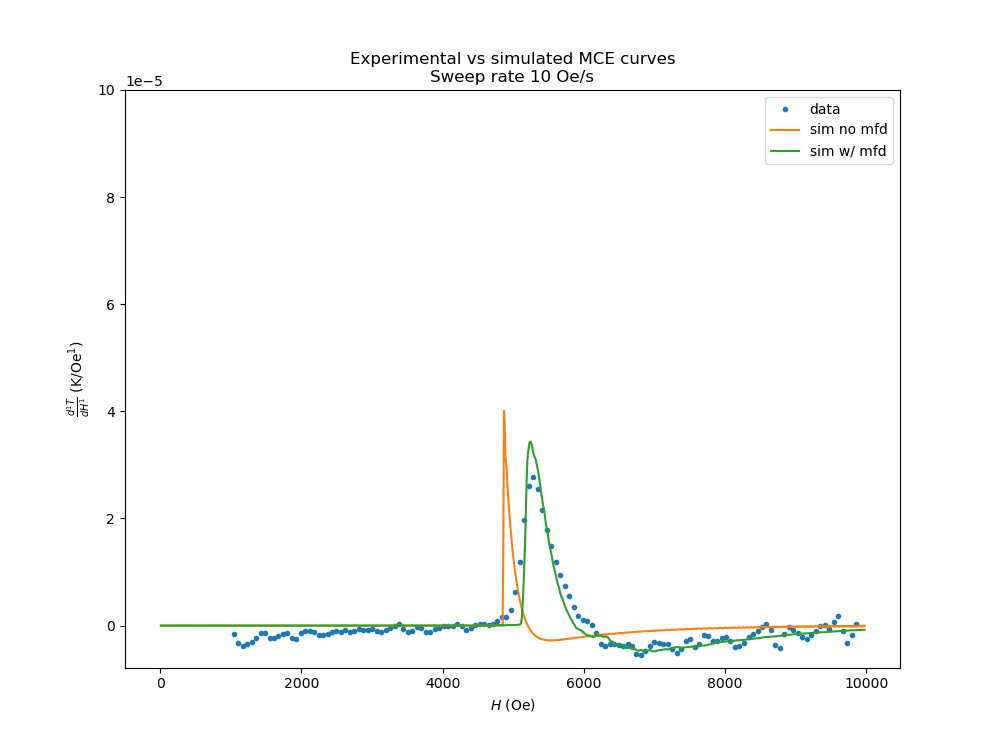

In [99]:
dHa = 10
sra = 10
temp = 1.
dataFilter = data_filter(H[runID][sra], Tpuck[runID][sra], Hmin=1e3, Hmax=9.9e3, Tbath=temp)
Hf = H[runID][sra][dataFilter]

# Plot the calculated MCE
fig, ax = plt.subplots()

Ha = np.arange(-50*binf, 1.5e4, dHa)# array of fields; see section intro
scaledHa = Ha*real_Hc0/Hc0
Hsel = np.logical_and(scaledHa>0, scaledHa<9.99e3)

if dHa==5:
    n = 2
    f_hmg = 1e-4
    f_mfd = 2e-3
    ymax = 1e-7
elif dHa==10:
    n = 1
    f_hmg = 2e-2
    f_mfd = 8e-2    
    ymax = 1e-4

plt.plot(Hf, eval(f'd{n}T')[runID][sra][dataFilter], '.', label='data')
plt.plot(scaledHa[Hsel], f_hmg*eval(f'd{n}Tx')[dHa][sra][temp]['homogeneous'][Hsel], label='sim no mfd')
plt.plot(scaledHa[Hsel], f_mfd*eval(f'd{n}Tx')[dHa][sra][temp]['mfd'][Hsel], label='sim w/ mfd')

# for binf in mfd_test.keys():
#     Tx[binf] = pd.Series(convolve(Tx[dHa][sra][temp]['homogeneous'], mfd_test[binf][::-1], mode='same')\
#                          /sum(mfd_test[binf]))
#     plt.plot(Ha[Hsel], Tx[binf][Hsel], label=f'mfd {binf:.0e} bins')

# plt.ylim(bottom=.49)
plt.title(''.join(['Experimental vs simulated MCE curves\n',
           f'Sweep rate {sra} Oe/s']))
plt.xlabel(r'$H$ (Oe)')
plt.ylabel(f'$\\frac{{d^{n}T}}{{dH^{n}}}$ (K/Oe$^{n}$)')
plt.ylim(top=ymax)
plt.legend()
cursor()

### Compute relative difference between critical fields extracted from measured and simulated MCE curves

#### To do as of 2021-06-12
* Add error bars, roughly equal to sweep rate
* Take values for T<=1.5K, where discrepancy between computed and measured Hc is <2% when computing Hc from 1st derivative
* Apply factor fhc = Hc[hmg]/Hc[mfd] to extract real Hc

In [119]:
Hcup[dHa][sra].keys()
eval(f'HTcd{n}')[runID][sra].keys()

dict_keys([0.7, 0.9, 1.0, 1.2, 1.4, 1.6, 1.8])

<IPython.core.display.Javascript object>


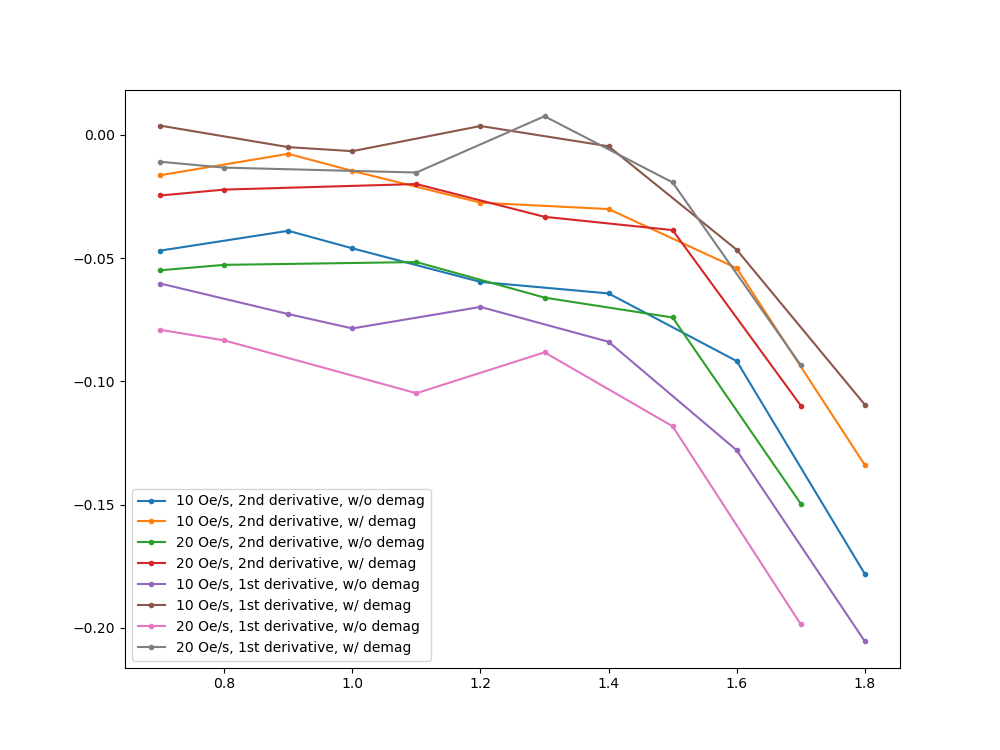

In [159]:
dHcup = {}
plt.figure()
for dHa in [5,10]:
    if dHa not in dHcup.keys():
        dHcup[dHa] = {}
    if dHa==10:
        n = 1
        nstr = '1st'
    elif dHa==5:
        n = 2
        nstr = '2nd'

    for sra in [10, 20]:
        if sra not in dHcup[dHa].keys():
            dHcup[dHa][sra] = {}
        for label in ['homogeneous', 'mfd']:
            if label not in dHcup[dHa][sra].keys():    
                dHcup[dHa][sra][label] = {}
            for Tb in (round(0.1*x,1) for x in range(7,19)):
                if Tb not in eval(f'HTcd{n}')[runID][sra].keys(): continue
                dHcup[dHa][sra][label][Tb] = (Hcup[dHa][sra][Tb][label]-eval(f'HTcd{n}')[runID][sra][Tb][0])/eval(f'HTcd{n}')[runID][sra][Tb][0]

            x,y = zip(*list(dHcup[dHa][sra][label].items()))
            if label=='mfd':
                labstr = 'w/ demag'
            else:
                labstr = 'w/o demag'
            plt.plot(x, y, '.-', label=f'{sra} Oe/s, {nstr} derivative, {labstr}')
    
plt.legend()

In [215]:
# Manual corrections to computational errors
if sample==samples[0]:
    for sr in [-14, 14]:
        try:
            del HTcd1[7][sr]
            del HTcd2[7][sr]
            del dHc[7][sr]
        except KeyError:
            continue
    runID, sr, Tb = 7, 28, .5
    HTcd1[runID][sr][Tb] = (H[runID][sr].loc[535], T[runID][sr].loc[535])#

elif sample==samples[1]:
    for sr in [-10, 10]:
        try:
            del HTcd1[0][sr][.7]
#             del HTcd2[0][sr][.7]
#             del dHc[0][sr][.7]
        except KeyError:
            continue

In [61]:
# Prepare saving figure & data
os.chdir(datFilePath[sample])
savedir = {}
for runID in runIDs:#runIDs:
    if sample==samples[0]:
        dirname = [s for s in next(os.walk('.'))[1] if f'Run{runID}' in s][0]
        savedir[runID] = f'{dirname}//{this_month}_MCE_analysis//'
    elif sample==samples[1]:
        savedir[runID] = f'{this_month}_{sample}_MCE_analysis//'
    Path(savedir[runID]).mkdir(parents=True, exist_ok=True)
    
header = 'Hc[max(dH/dT)] (Oe), T[Hc[max(dH/dT)]] (K), \
Hc[max(d^2H/dT^2)] (Oe), T[Hc[max(d^2H/dT^2)]] (K)'

In [192]:
list(hc['down'][-20].values())
hc['up']

0.9689922480620154

<IPython.core.display.Javascript object>


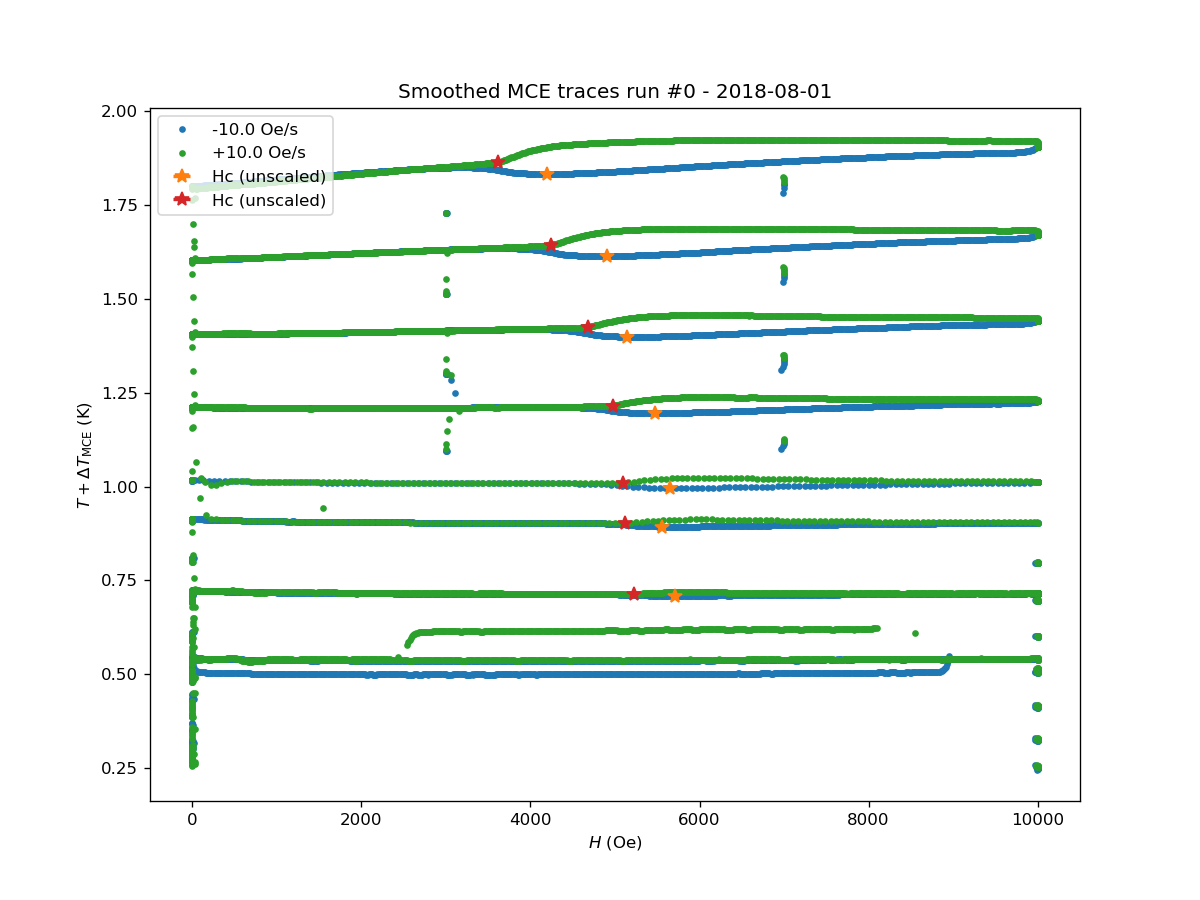

In [317]:
pltIDs = {samples[0]:[2], samples[1]:[0]}
dlabel = {'HTcd2':'max 2nd der.', 'HTcmin':'min(T)'}
darr = {}
# sr = -4
for runID in pltIDs[sample]:#runIDs:
    plt.figure()
    susr = usr[runID][-3]
    for sr in sweeprates[runID][abs(sweeprates[runID])==susr]:#[-susr, susr]:#
#     plt.ylim(np.arange(-1, 2, 2)*1e-4)
        plt.plot(H[runID][sr], T[runID][sr], '.', label=f'{sr:+.1f} Oe/s')
#         if sr>0:
#             arrays = ['dHc', 'HTcd2']
#         elif sr<0:
#             arrays = ['dHc', 'HTcmin']
            
        for elidx, elmt in enumerate(['dHc', 'HTc']):
            darr[elmt] = np.asarray(list(eval(f'{elmt}[runID][sr].values()')))
            if elidx>0:
                try:
                    plt.errorbar(darr[elmt][:,0], darr[elmt][:,1], xerr=darr['dHc'], ls='', lw=2,
                                 marker='*', ms=9, label='Hc (unscaled)')
                except ValueError: continue

#         plt.ylim(bottom=.4)
        plt.xlabel(xlabel_mce)
        plt.ylabel(ylabel_mce)
        plt.title(f'Smoothed MCE traces run #{runID} - {run_date[runID]}')
        plt.legend(loc='upper left')
        
        # Save data
#         saveHcData = f'{savedir[runID]}{str(today)}_run{runID}_sweeprate{int(sr):+d}Oeps_Hc'
#         data = np.vstack([pltHTcd1[:,0]*rescaling, pltHTcd1[:,1],
#                           pltHTcd2[:,0]*rescaling, pltHTcd2[:,1]]).T
#         np.savetxt(f'{saveHcData}.csv', data, fmt='%.3e', delimiter=',', header=header)

In [63]:
# saveHcFig = f'{savedir[runID]}{str(today)}_run{runID}_sweeprate+-{int(susr)}Oeps_Hc'
# plt.savefig(f'{saveHcname}.png', dpi=300)

## Create dataframe containing all values of critical field 
as extracted from both the first and second derivatives of the MCE data

In [359]:
HTcdf = {}

for runID in HTcmin.keys():
    HTcdf[runID] = {}
    for sr in HTcmin[runID].keys():
        # Create a dataframe for each value of sweeprate in a given run
        HTcdf[runID][sr] = pd.concat([pd.DataFrame(HTcmin[runID][sr]).T, 
                                      pd.DataFrame(HTcd2[runID][sr]).T,
                                      pd.Series(dHc[runID][sr])], axis=1)
        HTcdf[runID][sr].columns = ['Hcmin', 'Tcmin', 'Hcd2', 'Tcd2', 'dHc']
#             HTcdf[runID][sr]['dHc'] = abs(HTcdf[runID][sr]['Hcd1']-HTcdf[runID][sr]['Hcd2_raw'])
        HTcdf[runID][sr]['Hc'] = np.NaN
        HTcdf[runID][sr]['Tc'] = np.NaN
        HTcdf[runID][sr]['Date'] = run_date[runID]
        HTcdf[runID][sr]['Run #'] = runID
        HTcdf[runID][sr]['Sweeprate'] = sr
        HTcdf[runID][sr].reset_index(inplace=True)
        HTcdf[runID][sr].rename(columns={'index':'Tbath'}, inplace=True)
        for Tb in HTcmin[runID][sr].keys():
            row_sel = HTcdf[runID][sr]['Tbath']==Tb
            if sr<0:
                HTcdf[runID][sr].loc[row_sel,'Hc'] = HTcdf[runID][sr].loc[row_sel,'Hcmin']*hc['down'][sr][Tb]
                HTcdf[runID][sr].loc[row_sel,'Tc'] = HTcdf[runID][sr].loc[row_sel,'Tcmin']
            elif sr>0:
                HTcdf[runID][sr].loc[row_sel,'Hc'] = HTcdf[runID][sr].loc[row_sel,'Hcd2']*hc['up']
                HTcdf[runID][sr].loc[row_sel,'Tc'] = HTcdf[runID][sr].loc[row_sel,'Tcd2']

    # For a given run, concatenate dataframes at all sweeprates together
    HTcdf[runID]['all'] = pd.concat([HTcdf[runID][sr] for sr in HTcdf[runID].keys()], ignore_index=True)

# Concatenate dataframes of all runs together
HTcdf['all'] = pd.concat([HTcdf[runID]['all'] for runID in HTcdf.keys()], ignore_index=True)

# Rearrange columns 
cols = HTcdf['all'].columns.tolist()
cols = cols[-3:] + cols[:-3]
HTcdf['all'] = HTcdf['all'][cols]

# For sample LS5200, rescale values of critical field measured when sweeping field downwards
if sample==samples[0]:
    for der_idx in range(1,3):
        HTcdf['all'][f'Hcd{der_idx}_raw'] = HTcdf['all'][f'Hcd{der_idx}']
        HTcdf['all'][f'Hcd{der_idx}'] = np.where(HTcdf['all']['Sweeprate']<0, 
                                                 HTcdf['all'][f'Hcd{der_idx}_raw']*rescaling, 
                                                 HTcdf['all'][f'Hcd{der_idx}_raw'])


In [360]:
# for sr in HTcmin[runID].keys():
#     print(HTcmin[runID][sr].keys()==HTcd2[runID][sr].keys())
HTcmin[runID].keys()
HTcdf['all']
# HTcdf[runID][sr].loc[HTcdf[runID][sr]['Tbath']==1.1]['Hc']

,Date,Run #,Sweeprate,Tbath,Hcmin,Tcmin,Hcd2,Tcd2,dHc,Hc,Tc
0,2018-08-01,0,-20.0,0.6,5547.304280,0.594327,5365.072881,0.594733,61.225321,5127.674251,0.594327
1,2018-08-01,0,-20.0,0.7,5525.743262,0.687597,5370.007935,0.688159,61.225321,5060.204452,0.687597
2,2018-08-01,0,-20.0,0.8,5729.533546,0.783619,5316.565070,0.785435,61.225321,5227.676593,0.783619
3,2018-08-01,0,-20.0,1.1,5562.779427,1.067491,5206.235422,1.070215,61.225321,5066.283632,1.067491
4,2018-08-01,0,-20.0,1.3,5379.268459,1.263949,4957.935386,1.269872,61.225321,4876.979377,1.263949
5,2018-08-01,0,-20.0,1.5,5175.683007,1.468194,4655.192024,1.475997,61.225321,4671.194050,1.468194
6,2018-08-01,0,-20.0,1.7,4670.687479,1.682678,4232.579215,1.689646,61.225321,4185.203834,1.682678
7,2018-08-01,0,-10.0,0.7,5713.742931,0.708599,5727.557903,0.708623,30.612661,5176.465114,0.708599
8,2018-08-01,0,-10.0,0.9,5552.850403,0.893307,5552.850403,0.893307,30.612661,4975.672405,0.893307
9,2018-08-01,0,-10.0,1.0,5653.788731,0.996188,5338.157904,0.997639,150.708483,5057.056110,0.996188


<IPython.core.display.Javascript object>


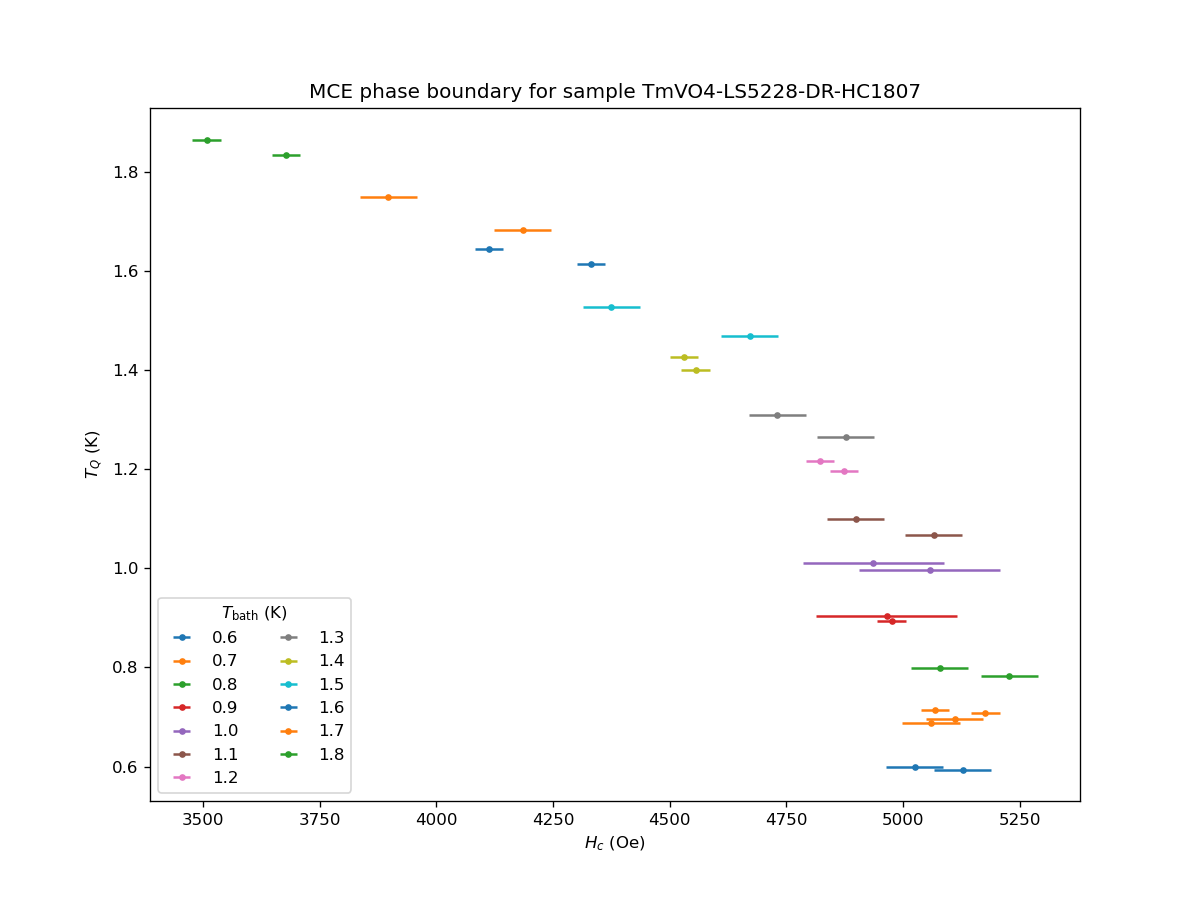

In [370]:
#### Plot critical field at each temperature vs sweeprate
# yhc = {}

plt.figure()
for Tb in np.unique(HTcdf['all']['Tbath'])[:]:
    # Hc_sel['upsweep'] = np.logical_and(HTcdf['all']['Tbath']==Tb, HTcdf['all']['Sweeprate']>0)
    # Hc_sel['downsweep'] = np.logical_and(HTcdf['all']['Tbath']==Tb, HTcdf['all']['Sweeprate']<0)
    Hc_sel = HTcdf['all']['Tbath']==Tb

    xhc = HTcdf['all'][Hc_sel]['Sweeprate']
    dyhc = HTcdf['all'][Hc_sel]['dHc']
#     yhc['downsweep'] = HTcdf['all'][(Hc_sel) & (HTcdf['all']['Sweeprate']<0)]['Hcd1']
#     yhc['upsweep'] = HTcdf['all'][(Hc_sel) & (HTcdf['all']['Sweeprate']>0)]['Hcd2']
#     yhc['all_sweeps'] = pd.concat([yhc['downsweep'], yhc['upsweep']])
    yhc = HTcdf['all'][Hc_sel]['Hc']
    thc = HTcdf['all'][Hc_sel]['Tc']
    
#     plt.errorbar(xhc, yhc, yerr=dyhc, fmt='.', label=f'{Tb}')
    plt.errorbar(yhc, thc, xerr=dyhc, fmt='.', label=f'{Tb}')
    # plt.errorbar(xhc['upsweep'], HTcdf['all'][Hc_sel[sweep]]['Hcd2_raw'], yerr=dyhc['upsweep'], fmt='.')
    # plt.errorbar(xhc['downsweep'], yhc['downsweep'], yerr=dyhc['downsweep'], fmt='.')
    plt.legend(loc='lower left', ncol=2, title='$T_\mathrm{{bath}}$ (K)')
#     plt.xlabel('Sweeprate (Oe/s)')
    plt.xlabel(r'$H_c$ (Oe)')
    plt.ylabel(r'$T_Q$ (K)')
    plt.title(f'MCE phase boundary for sample {sample}')

In [366]:
os.chdir(r'.\Extracted_critical_fields\Tc_vs_Hc')
print(os.getcwd())

C:\Users\Pierre\Desktop\Postdoc\TmVO4\TmVO4_heat-capacity\2018-08_TmVO4-LS5228\Extracted_critical_fields\Tc_vs_Hc


In [371]:
plt.savefig(f'{str(today)}_{sample}_Tc_vs_Hc.png', bbox_inches='tight', dpi=200)

In [ ]:
# Export dataframe to csv file
saveHcData = f'./Extracted_critical_fields/{str(today)}_{sample}_Hc_all_runs.csv'
# HTcdf['all'].to_csv(saveHcData, index=False)

In [ ]:
# Insert string of units in 2nd line of csv file
if sample==samples[0]:
    Hc_units = ',,Oe/s,K,Oe,K,Oe,K,Oe,Oe,Oe\n'# units corresponding to HTcdf['all'].columns
elif sample==samples[1]:
    Hc_units = ',,Oe/s,K,Oe,K,Oe,K,Oe\n'# units corresponding to HTcdf['all'].columns
try:
    with open(saveHcData, 'r+') as f:
        contents = f.readlines()# store file contents
        contents.insert(1, Hc_units)# insert string between first and second lines
        f.seek(0)# reset cursor to begining of file
#         f.writelines(contents)# rewrite file with new contents
except FileNotFoundError:
    pass

To do as of 2021-01-28:
* Fit with Rafael's predictions
    
Notes:
* For the case of the 'needle-shaped samples, simulated curves have their upturns coincide with those of the data when determining Hc from second derivatives of MCE data, both for up- and downsweep; confirm with data on sample measured in DR
* After rescaling Hc(downsweep) with mean(Hin/Hext), the critical fields of the up- and downsweeps agree well at all temperatures for the needle-shaped sample. For the DR sample, the critical fields of the upsweep extracted from the second derivative agree with those extracted from the 1st derivative for the downsweep

## Simulate MCE curves

In [64]:
# Callback function for debugging
def iter_callback(params, iter_num, resid, H, data=None, trace=None):
    print(iter_num, params['ODE_prefactor'].value)
    
class FakeLMFitResult:
    """
    Dummy class that has an attribute 'params', similar to the result of a fit with lmfit.
    """
    def __init__(self, params):
        self.params = params

In [115]:
# Function to compute variables required to simulate MCE curves
def xfit_mce(H, T, Tpuck, Tb, htcd2, fitRange, mfd, srpm, us, utmfd, fit=False, sample='TmVO4-LS5228-DR-HC1807'):
    d = {}
    Hc = {}
    for elmt in ['Hc', 'Hf', 'Tf', 'Hffit', 'Tffit', 'Tbath', 'prms', 'trace_str']:
        exec(f'{elmt} = []', d)
    for idx, sr in enumerate(srpm):#
        # select data to analyze; note: solve_ivp fails for H<1 Oe (H/Hc0<2e-3)
        dataFilter = np.logical_and(np.logical_and(H[sr]>10, H[sr]<9.99e3),
                                    np.round(Tpuck[sr], 1)==Tb)
        
        # Ignore datasets with too few datapoints
        if len(T[sr][dataFilter])<100: 
            continue
            
        Hf = H[sr][dataFilter]
        Tf = T[sr][dataFilter]
        d['Hf'].append(Hf)
        d['Tf'].append(Tf)
        
        # Compute the bath temperature, i.e. the temperature in the absence of MCE
        # Select temperatures in the range of magnetic fields between Hc and Hc-1000 Oe
        hc = htcd2[sr][Tb][0]
        Tsel = np.logical_and(Hf<hc, Hf>hc-1e3)
        d['Tbath'].append(mce.bath_temp([Tf[Tsel]]))
        if d['Tbath'] is None: 
            print('Could not compute the bath temperature.')
            continue
            
        # Select the range of magnetic fields on which to perform the fit
        Hf_filter = np.logical_and(d['Hf'][-1]>fitRange[0], d['Hf'][-1]<fitRange[1])
        d['Hffit'].append(d['Hf'][-1][Hf_filter])
        d['Tffit'].append(d['Tf'][-1][Hf_filter])
        
        # If the resulting dataset does not have enough data points, skip the fit
        if len(d['Hffit'][-1])<50: continue
        if sr>0: 
            d['trace_str'].append('upsweep')
            Hc[sr] = hc
        else: 
            d['trace_str'].append('downsweep')
            Hc[sr] = hc

        
    if len(d['Hf'])==0: 
        print('No data to plot/fit.')
        return None
    
    Tbm = np.mean(d['Tbath'])
    # Find MFD with temperature closest to Tbath
    Tbmfd, _ = mce.closest_mfd_values(Tbm, utmfd)
    Hc0 = 5e3
    mfd_key = (Hc0, Tbmfd[0])
    # Compute the number of datapoints in the range of the corresponding mfd
    hnpoints = abs(abs(d['Hf'][0]/Hc0-1).idxmin() - abs(d['Hf'][0]/Hc0-(1-mfd[mfd_key]['half_width'])).idxmin())
#     print(hnpoints)

    # Compute the corresponding histogram
    if sample=='TmVO4-LS5200':
        Hext = mfd_key[0]
    if sample=='TmVO4-LS5228-DR-HC1807':
        Hext = 1
    mfd[mfd_key]['hc'], mfd[mfd_key]['binCenters'], mfd[mfd_key]['binWidths'] = mfd_histogram(
        mfd[mfd_key]['data'], Hext, binfactor=hnpoints)

    for idx, sr in enumerate(srpm):#
        # Define fit parameters
        d['prms'].append(mce.mce_parameters(Hc=Hc[sr], sweeprate=us, 
                                            kappa=.1*np.sqrt(Tbm), 
                                            Tc0=2.2, Tbath=Tbm))
    if fit is True:
        out = minimize(mce.xmce_residual, d['prms'][-1], method='least_squares',
                       args=(d['Hffit'], d['Tffit'], d['trace_str']),
                       kws={'mfd_hc':mfd[mfd_key]['hc'], 'Tbath':d['Tbath']}, 
                       iter_cb=None)#, **{'ftol':1e-15})#, max_nfev=100)#)
    else:
        out = None
    
    return d['Hf'], d['Tf'], d['trace_str'], mfd_key, out, d['prms']

In [112]:
mce_fit[runID][sr].params
sr = 20
Tb = .8
Hc2 = HTcd2[runID][sr][Tb][0]
dataFilter = np.logical_and(np.logical_and(H[runID][sr]>10, H[runID][sr]<9.99e3),
                                    np.round(Tpuck[runID][sr], 1)==Tb)
Hf = H[runID][sr][dataFilter]
Tf = T[runID][sr][dataFilter]
Tsel = np.logical_and(Hf<Hc2, Hf>Hc2-1e3)
mce.bath_temp([Tf[Tsel]], rel_temp_var=2.5e-6)

0.7973508431689206

Using matplotlib backend: nbAgg


<IPython.core.display.Javascript object>


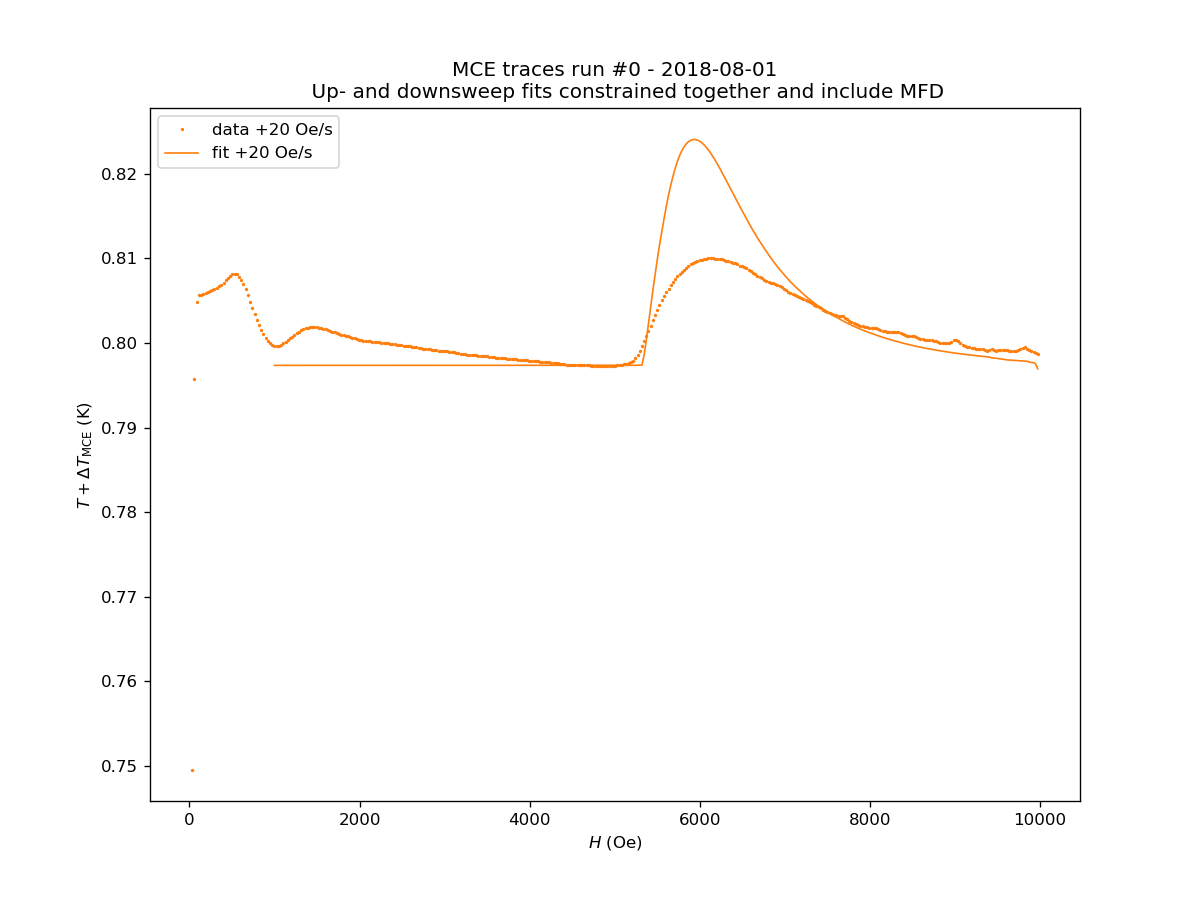

0.7950913671371518
0.7973508431689206


In [117]:
%matplotlib
runID = 0
for dico in [mce_fit, mce_sim]:
    if runID not in dico.keys():
        dico[runID] = {}

fitRange = {samples[0]:{2:[4e3, 9e3], 3:[4e3, 6e3], 4:[4e3, 6e3], 5:[4e3, 8e3], 7:[4e3, 6.3e3]},
            samples[1]:{0:[4e3, 9e3]}}
# prm_rng = {2:(range(0,3,2), range(1,len(utbath[2]))), 3:None}

for us in usr[runID][1:2]:
    lgd_labels = []
    plt.figure(num=int(us))
    srpm = sweeprates[runID][abs(sweeprates[runID])==us]
    for Tb in utbath[runID][6:7]:
        result = xfit_mce(H[runID], T[runID], Tpuck[runID], Tb, HTcd2[runID],
                          fitRange[sample][runID], mfd, srpm, us, utmfd, fit=True)
        if result is None: continue
        Hf, Tf, strace, mfd_key, out, prms = result
#         if out is not None:
#             mce_fit[runID][us] = out

        for sr in srpm[1:]:#
            idx = list(srpm).index(sr)
            if out is None:
                out = FakeLMFitResult(prms[idx])
                print(f'{sr:+.0f} Oe/s\t Tb = {Tb} K\t Hc = {out.params["Hc"].value:.0f} Oe\
                ODE prefactor = {out.params["ODE_prefactor"].value:.3f}')
                
            # sorted arguments avoid lines connecting low and high Hf values
            xhf = Hf[idx].sort_values()
            thf = Tf[idx][Hf[idx].sort_values().index]
            
            mce_sim[runID][sr] = mce.mce_residual(out.params, xhf, data=None, 
#                                                   trace=strace[idx], mfd_hc=None)
                                                  trace=strace[idx], mfd_hc=mfd[mfd_key]['hc'])
            mce_fit[runID][sr] = out
            out = None

            # Plot results
            srlabel = f'{sr:+.0f} Oe/s'
            plt.plot(xhf, thf, '.', color=f'C{idx}', markersize=2,
                     label=f'data {srlabel}' if srlabel not in lgd_labels else '_nolegend_')
        #     plt.plot(Hf, mce_sim[sr], '-', color=f'C{idx}', label=f'fit {sr:+.1f} Oe/s')
        
            # Plotting the fit 
#             cutoff = 20
            df_plt = pd.DataFrame(np.array([xhf, mce_sim[runID][sr]]).T)
            dfnz = df_plt[df_plt[0]>1e3]# ignore rows where computed MCE is 0
            plt.plot(dfnz[0], dfnz[1] ,
                     '-', linewidth=1, color=f'C{idx}',
                     label=f'fit {srlabel}' if srlabel not in lgd_labels else '_nolegend_')
            # Keep track of legend labels to avoid duplicates
            if srlabel not in lgd_labels:
                lgd_labels.append(srlabel)
    plt.title(f'MCE traces run #{runID} - {run_date[runID]}\n\
    Up- and downsweep fits constrained together and include MFD')
    plt.xlabel(xlabel_mce)
    plt.ylabel(ylabel_mce)
#     plt.ylim(bottom=.5)
    plt.legend(loc='upper left')
    
    # Save figure
#     dirname = [s for s in next(os.walk('.'))[1] if f'Run{runID}' in s][0]
#     savefitname = f'{dirname}//{this_month}_MCE_fitting//\
# {str(today)}_run{runID}_sweeprate+-{int(us)}Oeps_+fits_noMFD.png'
#     plt.savefig(savefitname, dpi=300)
cursor()

In [121]:
mce_sim[runID][sr]

array([1.84125743, 1.84125743, 1.84125743, 1.84125743, 1.84125743,
       1.84125743, 1.84125743, 1.84125743, 1.84125743, 1.84125743,
       1.84125743, 1.84125743, 1.84125743, 1.84125743, 1.84125743,
       1.84125743, 1.84125743, 1.84125743, 1.84125743, 1.84125743,
       1.84125743, 1.84125743, 1.84125743, 1.84125743, 1.84125743,
       1.84125743, 1.84125743, 1.84125743, 1.84125743, 1.84125743,
       1.84125743, 1.84125743, 1.84125743, 1.84125743, 1.84125743,
       1.84125743, 1.84125743, 1.84125743, 1.84125743, 1.84125743,
       1.84125743, 1.84125743, 1.84125743, 1.84125743, 1.84125743,
       1.84125743, 1.84125743, 1.84125743, 1.84125743, 1.84125743,
       1.84125743, 1.84125743, 1.84125743, 1.84125743, 1.84125743,
       1.84125743, 1.84125743, 1.84125743, 1.84125743, 1.84125743,
       1.84125743, 1.84125743, 1.84125743, 1.84125743, 1.84125743,
       1.84125743, 1.84125743, 1.84125743, 1.84125743, 1.84125743,
       1.84125743, 1.84125743, 1.84125743, 1.84125743, 1.84125

## Tests
This section is for tests.

### Test computation of MCE curve convolved with MFD
Outdated as of 2021-01-28.

In [ ]:
runID = 0
sr = 10
Tb = 1.0
dataSel = np.logical_and(np.logical_and(H[runID][sr]>10, H[runID][sr]<9.99e3),
                         np.round(Tpuck[runID][sr], 1)==Tb)
Hf = H[runID][sr][dataSel]
Tf = T[runID][sr][dataSel]

In [ ]:
Ttest = Tb
closest2T, Tweights = mce.closest_mfd_values(Ttest, utmfd)
print(Ttest, closest2T, Tweights)
Htest = Hf[200]
closest2H, Hweights = mce.closest_mfd_values(Htest, uhext)
print(Htest, closest2H, Hweights)

In [ ]:
# Update mfd_key with the closest temperature
mfd_key = (5e3, closest2T[0])

# Compute the number of datapoints in the range of the corresponding mfd
hnpoints = abs(Hf/Hc-1).idxmin() - abs(Hf/Hc-(1-mfd[mfd_key]['rel_width'])).idxmin()

# Compute the corresponding histogram
mfd[mfd_key]['hc'], mfd[mfd_key]['binCenters'], mfd[mfd_key]['binWidths'] = \
mfd_histogram(mfd[mfd_key]['data'], Hext, nbins=hnpoints)

In [ ]:
prms = mce.mce_parameters(Hc0=Hc0, sweeprate=-sr, Tc0=Tc0, Tbath=Tb)
Tcalc = mce.mce_residual(prms, Hf, trace='downsweep')
Tcalc[int(len(Tcalc)/2)-50:int(len(Tcalc)/2)+50]

In [ ]:
from scipy.signal import convolve
# Update mfd_key to use the mfd closest to the critical field (H ~ 5 kOe)
Tout = convolve(Tcalc, mfd[mfd_key]['hc'][::-1], mode='same')/sum(mfd[mfd_key]['hc'])
# Check that the convolution acts on a wide enough range of magnetic fields. 
# Might require some kind of adaptability of its width...
# At the very least, make sure the width is correct around the critical field
Tout[int(len(Tout)/2)-50:int(len(Tout)/2)+50]

In [ ]:
# Plot convolution of magnetic field with MFD
# fig, ax = plt.subplots()
plt.plot(Hf, Tcalc)
plt.plot(Hf, Tout)
cursor()